# **Wafer Defect Classification Project**
MATSCI176 Winter Quarter 2025\
By Haley Stafford and Ajai Romana

___

#### **Project Description**
In semiconductor manufacturing, defect detection and classification are critical for ensuring the quality of wafers produced during the fabrication process. Wafer maps, which visually represent the state of each chip on a wafer, reveal patterns of defects that indicate underlying issues in the manufacturing process or equipment. Automating the classification of these defect patterns is essential for timely quality control and reducing human intervention on the production line. However, computational efficiency remains a challenge when deploying machine learning models in real-world manufacturing environments, where time and resources are limited, and high accuracy is paramount.

Initially, this project explored Naive Bayes as a baseline model to quickly test the feasibility of automated defect detection. While Naive Bayes offers impressive speed and minimal computational overhead, its performance in terms of classification accuracy was limited, particularly when handling more complex defect patterns. The model achieved only about 51% accuracy, which, while fast, was insufficient for the task. As a result, the project shifted focus towards optimizing more advanced models, such as Convolutional Neural Networks (CNNs), which, though more computationally demanding, have the potential to achieve much higher classification accuracy.

The main objective of this project was to develop a CNN model that could accurately classify defective wafers into one of eight defect categories. To achieve this, a 3-layer CNN architecture was chosen for its balance of model complexity and computational efficiency. Hyperparameter optimization was employed to tune various aspects of the model in order to improve classification accuracy without significantly increasing computational cost. Given computational limitations, a random hyperparameter search method was used to explore different configurations of the model's parameters.

Random Hyperparameter Search was chosen over more exhaustive methods like grid search due to its computational efficiency. The search space consisted of several hyperparameters that could influence model performance, and the search was limited to 30 iterations due to the computational constraints. Although this was a modest search, it is believed that the results are reasonable given the trade-off between accuracy and computation time.

The following CNN hyperparameter space was explored for optimization:
- Filter Sizes: [(32, 64, 128), (64, 128, 256)]
- Kernel Sizes: [((3, 3), (3, 3), (3, 3)), ((5, 5), (3, 3), (3, 3))]
- Activation Functions: ['relu', 'tanh', 'sigmoid']
- Pooling Types: ['Max', 'Average']
- Dropout Rates: [0.2, 0.5, 0.7]
- Dense Units: [64, 128, 256]

Through 30 random iterations of hyperparameter search, we were able to identify a high-performing configuration of the 3-layer CNN. The optimal model produced a test accuracy of **[to be determined]**, which significantly improved upon the Naive Bayes baseline. The results of the hyperparameter search, including the test accuracy and other performance metrics, are detailed in the project findings.

While further optimization could be achieved through more iterations or alternative methods like grid search, the random search approach provided valuable insights into how different hyperparameter configurations influence the model's classification accuracy. This work demonstrates that, even with limited computational resources, it is possible to achieve substantial improvements in accuracy using CNNs for wafer map defect classification.
___

## **1. System Set-up**
In this block of code, we set up the environment by importing the necessary libraries to enable deep learning, data manipulation, and data visualization. Each library has been selected based on its functionality to facilitate the smooth implementation of our project.

In [1]:
# Import libraries to enable deep learning, data manipulation, and data visualization
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For Data Pre-processing and Augmentation
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For Naive Bayes Classification Method
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# For Convolutional Neural Network (CNN) Classification Method
import tensorflow as tf
from tensorflow.keras import layers, models

# For CNN Hyperparameter Optimization
from sklearn.model_selection import ParameterGrid
import time
import random

/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Data Acquisition**
The dataset used in this project is the publically-available WM811K dataset from KaggleHub, which contains silicon wafer maps and their failure type. A wafer map represents a detailed image of a silicon wafer, showing areas of defects (if any). Each wafer map is associated with a label indicating the type of defect present.

- **Source**: https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map

- **Size:** The dataset contains over 800,000 wafer maps and their corresponding defect pattern type. Most of these wafer maps are non-defective and are thus left out of the analysis which seeks to classify defective wafers into one of eight failureType patterns.

- **waferMap:** A 2D grid comprised of an array of arrays that represents the condition of the semiconductor wafer. Each element in the grid corresponds to a specific pixel on the wafer's surface where 0, 1 and 2 represent the regions with no die, a normal die and a defective die respectively.

- **failureType:** Each wafer map is labeled with one of eight failure types: “Scratch”, “Edge-Ring”, “Edge-Loc”, “Center”, “Random”, “Loc”, “Near-full” and “Donut”.

In [2]:
# Load the Silicon Wafer Map Data from Kaggle into a dataframe
path = kagglehub.dataset_download("qingyi/wm811k-wafer-map")
pickle_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.pkl'):
            pickle_file = os.path.join(root, file)
            break
    if pickle_file:
        break
data = pd.read_pickle(pickle_file)

# Clean and Isolate Defective Wafer Maps
defective_wafers = data[
    (data['failureType'].astype(str).str.contains("'none'", na=False) == False) & 
    (data['failureType'].astype(str) != '[]')
]
defective_wafers = defective_wafers.reset_index(drop=True)

# Drop unnecessary columns and reformat failureType to string
defective_wafers = defective_wafers.drop(columns=['dieSize', 'lotName', 'waferIndex', 'trianTestLabel'])
defective_wafers['failureType'] = defective_wafers['failureType'].apply(lambda x: x[0][0])

To preprocess the relevant 'waferMap' and 'failureType' data for classification, we first explore the dataset to understand its shape, columns, and types of data present:

In [3]:
# Print the basic structure of the dataset
print("Dataset Shape:", defective_wafers.shape)
print("Columns:", defective_wafers.columns)
print("Data Types:", defective_wafers.dtypes)

Dataset Shape: (25519, 2)
Columns: Index(['waferMap', 'failureType'], dtype='object')
Data Types: waferMap       object
failureType    object
dtype: object


The following helper functions plot an example wafer map for each of the eight failure types:

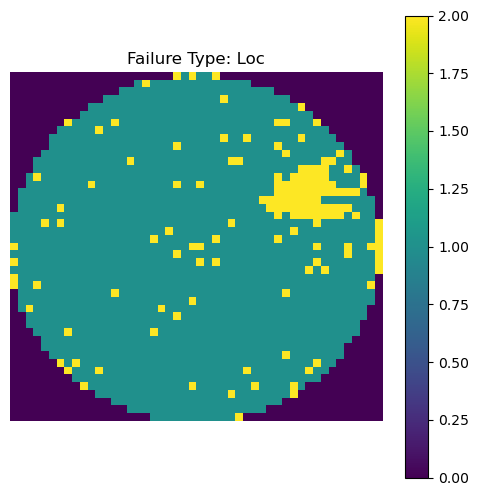

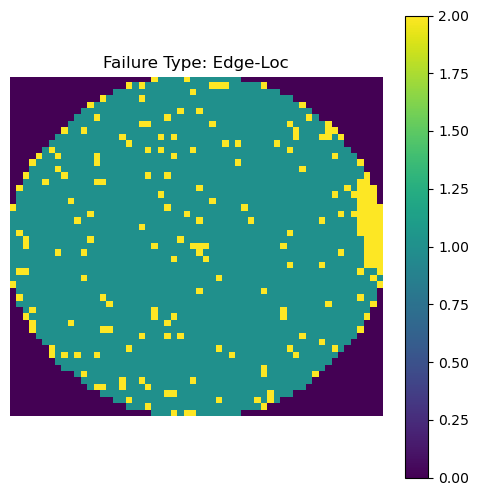

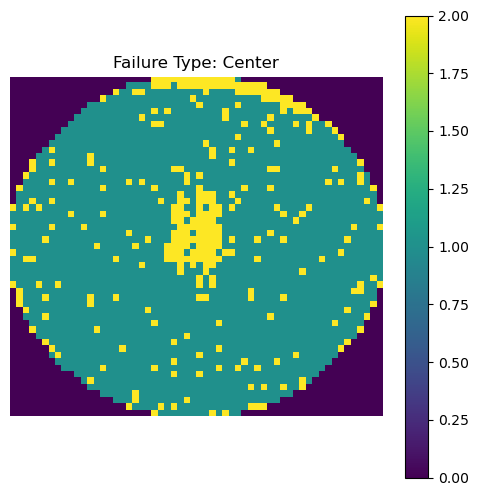

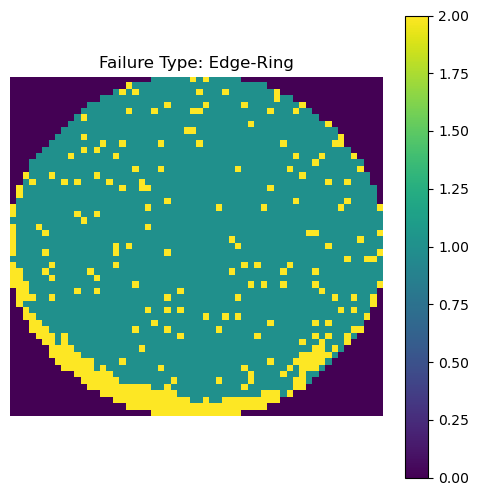

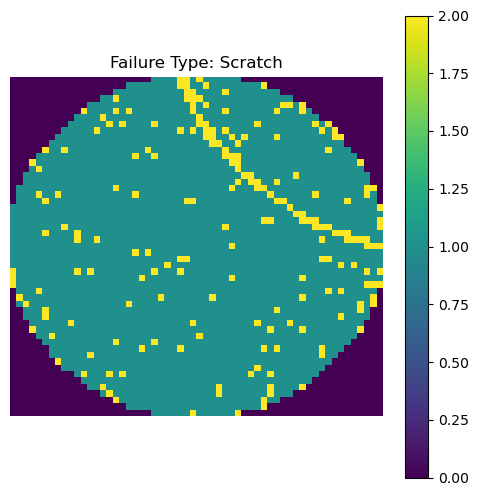

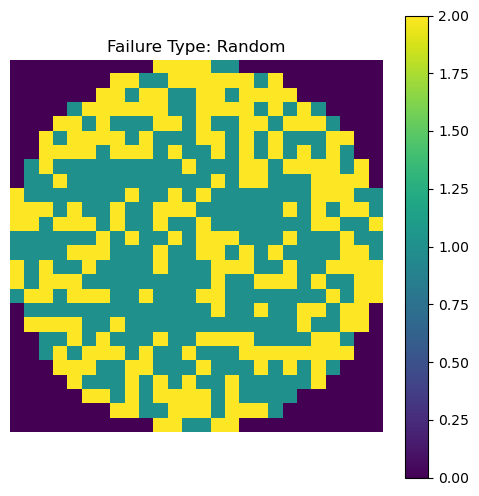

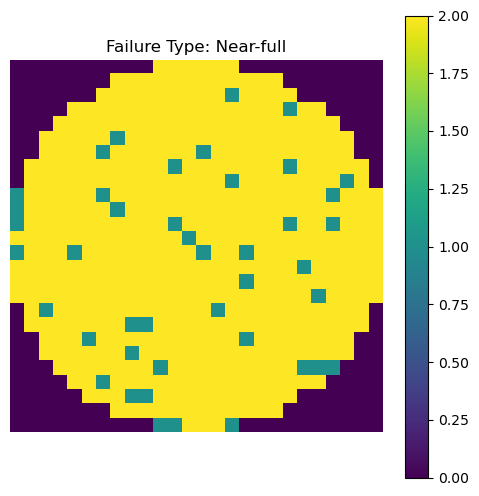

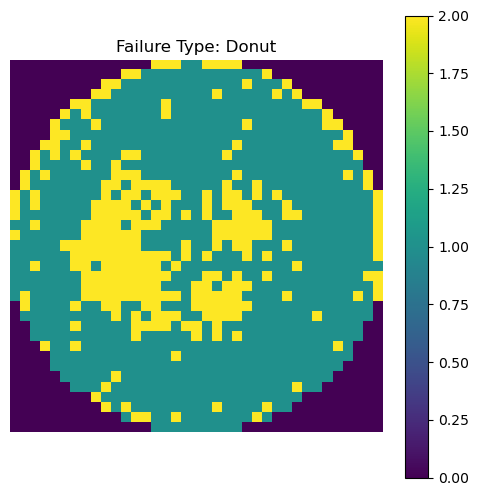

In [4]:
# Helper function that plots a single wafer map
def plot_wafer_map(wafer_map, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(wafer_map, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Helper function that plots an example wafer map for each failureType
def plot_example_wafer_maps_by_type(defective_wafers):
    # Get unique failureTypes
    failure_types = defective_wafers['failureType'].unique()

    # Plot the wafer map for the first instance of each failure type
    for failure_type in failure_types:
        example_wafer_map = defective_wafers[defective_wafers['failureType'] == failure_type].iloc[0]['waferMap']
        plot_wafer_map(example_wafer_map, f"Failure Type: {failure_type}")

plot_example_wafer_maps_by_type(defective_wafers)

As shown above, not all wafer maps in the dataset have the same shape.

From printing out the wafer map shape statistics, we see that the largest wafer map has a shape of (212, 84) and the smallest one has a shape of (22, 35). Because the dimensions of these wafer maps vary significantly, we need to standardize them to a consistent shape to ensure they can be effectively processed by machine learning models.

Number of Unique Shapes: 329
Largest Wafer Map Shape: (212, 84)
Smallest Wafer Map Shape: (22, 35)


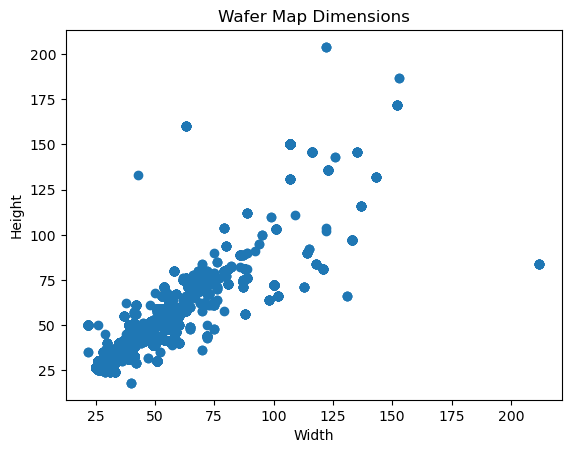

In [5]:
shapes = [wafer.shape for wafer in defective_wafers['waferMap']]
unique_shapes = set(shapes)
print("Number of Unique Shapes:", len(unique_shapes))
print("Largest Wafer Map Shape:", max(unique_shapes))
print("Smallest Wafer Map Shape:", min(unique_shapes))

# Plot the wafer map dimensions to identify best shape for model
shapes_x = [tuple[0] for tuple in shapes]
shapes_y = [tuple[1] for tuple in shapes]
plt.scatter(shapes_x, shapes_y)
plt.title("Wafer Map Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

After reviewing the shape distribution of the wafer map dimensions, we observe that the wafer maps' median width is 39 and median height is 37.

In [6]:
average_dimension = (int(np.median(shapes_x)), int(np.median(shapes_y)))
print("Median Wafer Map Shape:", average_dimension)

Median Wafer Map Shape: (39, 37)


Given that these dimensions are relatively close, we have decided to standardize all wafer maps to the square shape of (39, 39).

This square shape is advantageous because it maintains a similar aspect ratio to the majority of the wafer maps, avoids unnecessary stretching, and simplifies the convolution process in the machine learning model. By resizing to (39, 39), we strike a balance between preserving the original wafer map data's features while ensuring a consistent size input for a CNN.

In [7]:
# Target size for all wafer maps after preprocessing
target_size = (39, 39)

As shown below, there is a severe imbalance in the number of occurences for each failureType category. For example, 'Edge-Ring' failure type has 9680 samples while the 'Near-full' failure type only has 149.

In [8]:
print(defective_wafers['failureType'].value_counts())

failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: count, dtype: int64


Consequently, we also need to augment the data to re-balance this distribution and ensure all failureType categories are more evenly represented. This is critical to prevent the classification model to overfitting to more common defect patterns.

## **3. Data Preprocessing**
Before training classification models, we need to preprocess the data to ensure that all input data is consistent and avoid overfitting to certain classes. Specifically, we need to address the issues of inconsistent waferMap sizes and imbalanced failureType categories. In this section, we focus on standardizing the wafer map sizes and augmenting the data to rebalance the dataset.

### **A. Standardize the Wafer Map Sizes**
Since wafer maps in the dataset have varying shapes, we employ bilinear interpolation to standardize their size to (39, 39).

Bilinear interpolation is a rescaling technique that adjusts the size of an image by considering the closest 2x2 matrix of known pixel values around each unknown pixel, averaging them to estimate new pixel values. This method preserves the general structure of the image and is effective for resizing while maintaining smooth transitions between pixel values.

The `scale_wafer_maps` function resizes all wafer maps in the dataset to the user-input target_size (i.e. (39, 39)) using bilinear interpolation. The resulting output is a dataframe with consistently-sized wafer maps.

In [9]:
def scale_wafer_maps(target_size):
    scaled_wafers = defective_wafers.copy()
    standardized_maps = []
    for wafer_map in defective_wafers['waferMap']:
        # Convert numpy array to PIL Image
        img = Image.fromarray(wafer_map)
        
        # Resize the image
        resized_img = img.resize(target_size, Image.BILINEAR)
        
        # Convert back to numpy array and append to standardized maps
        resized_map = np.array(resized_img)
        standardized_maps.append(resized_map)
    scaled_wafers['waferMap'] = standardized_maps
    return scaled_wafers

The plots below shows a wafer map before and after scaling:

Wafer map before resizing:


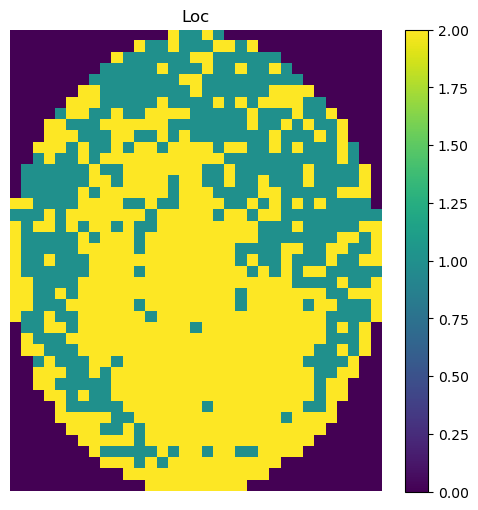

In [10]:
print("Wafer map before resizing:")
plot_wafer_map(defective_wafers['waferMap'][25000], defective_wafers['failureType'][25000])

Wafer map after resizing:


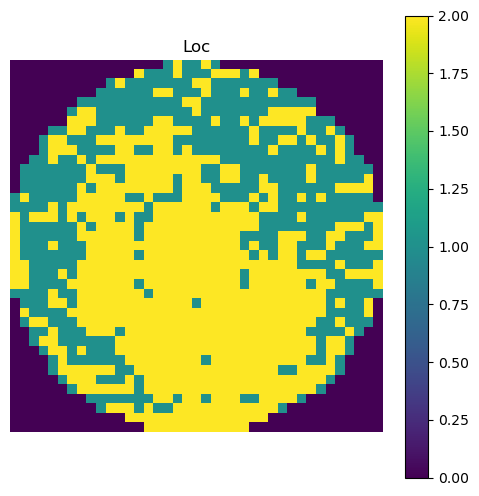

In [11]:
print("Wafer map after resizing:")
scaled_defective_wafers = scale_wafer_maps(target_size)
plot_wafer_map(scaled_defective_wafers['waferMap'][25000], scaled_defective_wafers['failureType'][25000])

As shown above, scaling slightly distorts some of the irregularly-shaped wafer maps. However, because the majority of the wafer maps are square-shaped, the distortion is minimal for most cases.

###  **B. Augment the Data**
Data augmentation is an essential technique for enhancing the diversity of the dataset and preventing overfitting, especially when dealing with imbalanced data. In the context of wafer maps, augmenting the data involves applying random transformations such as rotation, shifting, shearing, and flipping. These transformations help generate new variations of the existing wafer maps, thus increasing the number of samples available for training the classification models.

By artificially expanding the dataset, we reduce the risk of the model overfitting to the most frequent failure types and improve its ability to generalize across all categories.

`augment_data` takes in original defective_wafers dataframe and applies data augmentation techniques to generate a more balanced dataset. It utilizes various transformations, including rotation, shifting, shearing, zooming, and flipping, to create new versions of the original wafer maps while preserving their corresponding labels. The function reduces class imbalance to improve the model's generalizability.

In [12]:
def augment_data(defective_wafers):
    target_count = int(0.75*max(defective_wafers['failureType'].value_counts()))
    augmented_wafer_maps = []
    augmented_labels = []

    # Set up the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,        # Random rotations
        width_shift_range=0.2,    # Horizontal shifts
        height_shift_range=0.2,   # Vertical shifts
        shear_range=0.2,          # Shear transformation
        zoom_range=0.2,           # Zoom in/out
        horizontal_flip=True,     # Horizontal flip
        fill_mode='nearest'       # Filling the areas after transformation
    )
    
    # Iterate over each failure type in 'failureType' column
    for failure_type in defective_wafers['failureType'].unique():
        # Get all wafer maps and labels for the current failure type
        wafer_maps = defective_wafers[defective_wafers['failureType'] == failure_type]['waferMap'].values
        labels = defective_wafers[defective_wafers['failureType'] == failure_type]['failureType'].values
        
        # Calculate how many more samples are needed to reach the target count
        num_samples = len(wafer_maps)
        if num_samples >= target_count:
            # If the number of samples is already equal or greater than the target, add them as is
            augmented_wafer_maps.extend(wafer_maps)
            augmented_labels.extend(labels)
            continue
        
        # Prepare the images for augmentation (reshape to 4D tensor for ImageDataGenerator)
        wafer_maps = np.array([wafer_map.reshape(target_size[0], target_size[1], 1) for wafer_map in wafer_maps])

        # Generate augmented images using the datagen.flow() method
        augmented_batch = datagen.flow(wafer_maps, batch_size=1, shuffle=False)

        # Augment the wafer maps and labels until we reach the target count
        count = 0
        while num_samples + count < target_count:
            augmented_image = next(augmented_batch)  # Get next augmented image
            augmented_wafer_maps.append(augmented_image[0].reshape(target_size[0], target_size[1]))  # Store the augmented wafer map
            augmented_labels.append(failure_type)  # Store the corresponding label
            count += 1

            # Break if we have augmented enough samples for this failure type
            if count >= (target_count - num_samples):
                break
        
        # Add the original wafer maps if there were not enough augmented ones
        augmented_wafer_maps.extend(wafer_maps)
        augmented_labels.extend(labels)
        
    # Convert augmented data into a DataFrame to return
    augmented_data = pd.DataFrame({
        'failureType': augmented_labels,
        'waferMap': augmented_wafer_maps
    })

    # Return the augmented data
    return augmented_data


Before applying augmentation, the dataset is imbalanced, with some failure types having significantly fewer examples than others. This imbalance could cause the model to overfit to the more frequent failure types, resulting in poor generalization across all categories.

As shown in the code below, `augment_data` transforms the defective_wafers dataframe so that each category has a more balanced number of samples. We arbitrarily set a target count of 75% of the largest category size ('Edge-Ring'). This allows us to create a more balanced dataset without overfitting, giving each category enough representation while preventing any one class from dominating. 

This approach ensures that the model is exposed to a diverse range of defect patterns from all failure types, improving its ability to generalize across different wafer maps.

In [13]:
print("Before augmentation: ", defective_wafers['failureType'].value_counts())
augmented_defective_wafers = scale_wafer_maps(target_size)
augmented_defective_wafers = augment_data(augmented_defective_wafers)
print("\n After augmentation: ", augmented_defective_wafers['failureType'].value_counts())

Before augmentation:  failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: count, dtype: int64

 After augmentation:  failureType
Edge-Ring    9680
Loc          7260
Edge-Loc     7260
Center       7260
Scratch      7260
Random       7260
Near-full    7260
Donut        7260
Name: count, dtype: int64


## **4. Classification Methods**
We initially explored the Naive Bayes algorithm as a baseline classification method due to its simplicity and fast execution time. However, we quickly realized while computationally efficient, Naive Bayes is inadequate for defect classification given its accuracy of around 51%. This low performance makes it unsuitable for real-world applications in semiconductor manufacturing defect classification.

Recognizing the limitations of Naive Bayes, we shifted focus to Convolutional Neural Networks (CNNs), which are more powerful in capturing spatial hierarchies in image data. Specifically, we aimed to optimize the hyperparameters of a 3-layer CNN to maximize its classification accuracy. The goal was to develop a high-accuracy CNN model that, while more computationally intensive than Naive Bayes, could still deliver a reasonable run-time performance by optimizing the model's hyperparameters.

In the following analysis, we seek to tune the CNN's hyperparameters using random search to identify the best configuration for both accuracy and efficiency in the task of wafer defect classification.

### **A. Naive Bayes**
To implement and evaluate the Naive Bayes classifier, `classify_NB` calls `scale_wafer_maps` to resize the wafer maps to the input target_size, calls `augment_data` to ensure balanced representation of all failure types, and then applies a Naive Bayes classifier to train and test the model using an 80% train-20% test split.

In [14]:
def classify_NB(target_size):
    # Data Preprocessing
    standardized_defective_wafers = scale_wafer_maps(target_size)
    augmented_defective_wafers = augment_data(standardized_defective_wafers)
    
    # Prepare feature and labels for Naive Bayes classifier
    X = np.array([wafer_map.flatten() for wafer_map in augmented_defective_wafers['waferMap']])  # Flatten to 2D array
    y = augmented_defective_wafers['failureType']
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

    # Train the model
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    # Predict labels
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=1))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Print overall accuracy
    accuracy = clf.score(X_test, y_test)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

In [15]:
classify_NB(target_size)

Classification Report:
              precision    recall  f1-score   support

      Center       0.37      0.04      0.07      1412
       Donut       0.46      0.60      0.52      1466
    Edge-Loc       0.33      0.01      0.02      1458
   Edge-Ring       0.39      1.00      0.56      1876
         Loc       0.23      0.03      0.06      1463
   Near-full       0.93      0.91      0.92      1491
      Random       0.65      0.71      0.68      1478
     Scratch       0.53      0.67      0.59      1456

    accuracy                           0.52     12100
   macro avg       0.48      0.50      0.43     12100
weighted avg       0.48      0.52      0.43     12100


Confusion Matrix:
[[  58  363    3  814   14   32   52   76]
 [  56  875    1  105   78    4  247  100]
 [   2   96   17 1008   17    5   67  246]
 [   0    0    0 1876    0    0    0    0]
 [  16  183   15  697   47   10   50  445]
 [   0    0    0    0    0 1353  138    0]
 [  21  236    0  102    5   54 1048   12]
 [   4

While the ~51.6% classification accuracy achieved using Naive Bayes is much better than random chance, this is still not ideal for real-world applications.

Given that Naive Bayes assumes feature independence and doesn't account for spatial correlations in image data, it struggles with tasks like wafer map classification, where the spatial arrangement of pixels holds valuable information.

Convolutional Neural Networks (CNNs) are specifically designed for image data and are known for their ability to automatically learn spatial hierarchies of features. Because defect patterns are spatially distributed across the wafer maps, CNNs are expected to perform better than Naive Bayes in this context.

### **B. Convolutional Neural Networks (CNNs)**

After exploring Naive Bayes as a baseline classification method, we explored optimizing the hyperparameters of a 3-layer Convolutional Neural Network (CNN) to maximize classification accuracy. 

The following search space, limited by device hardware, was explored to find the best hyperparameters for a 3-layer CNN: 

In [16]:
# Hyperparameter Search Space
filter_sizes_list = [(32, 64, 128), (64, 128, 256)]
kernel_sizes_list = [((3, 3), (3, 3), (3, 3)), ((5, 5), (3, 3), (3, 3))]
activation_list = ['relu', 'tanh', 'sigmoid']
pool_type_list = ['Max', 'Average']
dropout_rates = [0.2, 0.5, 0.7]
dense_units_list = [64, 128, 256]

Instead of testing every possible combination through grid hyperparameter search, we employed random search by randomly sampling combinations of hyperparameters for each iteration and training the model with each combination. Again, device hardware limitations are why we used random search rather than an iterative approach that explores every possiible combination.

To identify the best combination of hyperparameters to maximize classification accuracy, the following helper functions were employed:

`build_model()` constructing a CNN model using adjustable hyperparameters. It allows flexibility in specifying various configurations, such as:
- **Filter Sizes**: Number of filters in the convolutional layers.
- **Kernel Sizes**: Size of the convolutional kernels.
- **Activation Functions**: Activation functions for each layer.
- **Pooling Types**: Whether to use MaxPooling or AveragePooling.
- **Dropout Rate**: To reduce overfitting.
- **Dense Units**: Number of units in the fully connected (dense) layer.

In [2]:
def build_model(target_size, 
                 filter_sizes=(32, 64, 128), 
                 kernel_sizes=((3, 3), (3, 3), (3, 3)),
                 activation='relu', 
                 pool_type='Max', 
                 dropout_rate=0.5, 
                 dense_units=128):
    
    model = models.Sequential()
    
    # Add convolutional layers with variable filter sizes and kernel sizes
    for i in range(len(filter_sizes)):
        model.add(layers.Conv2D(filter_sizes[i], kernel_sizes[i], activation=activation, input_shape=(target_size[0], target_size[1], 1) if i == 0 else None))
        # Add pooling layer based on user input (MaxPooling or AveragePooling)
        if pool_type == 'Max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        elif pool_type == 'Average':
            model.add(layers.AvgPool2D(pool_size=(2, 2)))
        
    model.add(layers.Dropout(dropout_rate)) # Add a dropout layer to reduce overfitting
    model.add(layers.Flatten()) # Flatten the output for the fully connected layer
    model.add(layers.Dense(dense_units, activation=activation)) # Add a dense layer with the specified number of units
    model.add(layers.Dense(8, activation='softmax')) # Output layer with softmax activation for 8 class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Compile the model
    return model


`train_and_evaluate_CNN` trains and evaluates a CNN model on the defective_wafers dataset, taking in the same CNN hyperparameter inputs as `build_model`. It first preprocesses the the data by calling `scale_wafer_maps` and `augment_data` and then builds the model using the `build_model` helper function. After training and evaluating the model's performance using a 80% train-20% test split, it prints a classification report and outputs a confusion matrix to assess the model's performance. It also plots the training versus validation accuracy and loss over epochs to visualize the model's learning process. Finally, it returns the training history and test accuracy for further analysis and model comparison.

In [ ]:
def train_and_evaluate_CNN( target_size, 
                            filter_sizes=(32, 64, 128), 
                            kernel_sizes=((3, 3), (3, 3), (3, 3)), 
                            activation='relu', 
                            pool_type='Max', 
                            dropout_rate=0.5, 
                            dense_units=128, 
                            epochs=10, 
                            batch_size=32):

    # Data Preprocessing
    standardized_defective_wafers = scale_wafer_maps(target_size)
    augmented_defective_wafers = augment_data(standardized_defective_wafers)

    # Prepare the data
    X = augmented_defective_wafers['waferMap']
    X = np.array([wafer_map.reshape(target_size[0], target_size[1], 1) for wafer_map in X])
    y = augmented_defective_wafers['failureType']

    # Encode string labels into numerical format
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split the data into training and test sets with an 80% train-20% test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Ensure data is float32 so CNN model can interpret it
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Build the CNN model using the helper function
    model = build_model(target_size, 
                        filter_sizes=filter_sizes, 
                        kernel_sizes=kernel_sizes, 
                        activation=activation, 
                        pool_type=pool_type, 
                        dropout_rate=dropout_rate, 
                        dense_units=dense_units)

    # Train the model using the training data
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

    # Generate confusion matrix and classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=le.classes_, zero_division=1))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

    # Plot the training vs validation accuracy over epochs to visualize training process
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot the training vs validation loss over epochs to visualize training process
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return history, test_accuracy

`random_hyperparameter_search` performs a random search over a specified set of hyperparameters to identify the best model configuration for classifying defective wafers. The function randomly samples different combinations of the following hyperparameters: filter sizes, kernel sizes, activation functions, pooling types, dropout rates, and the number of dense units.

For each sampled combination, the function builds a CNN using `build_model`, trains it on the provided defective_wafers dataset and evaluates its performance using `train_and_evaluate_CNN`. The function captures key performance metrics including test accuracy, train accuracy, validation accuracy, train loss, validation loss, and the variance between training and validation accuracy. It stores the results for each iteration, and once all iterations are complete, the results are exported an Excel file for further analysis. This allows for a detailed comparison of model performance across different hyperparameter configurations.

In [ ]:
def random_hyperparameter_search(defective_wafers, target_size, n_iter):
    ## Hyperparameter search space
    filter_sizes_list = [(32, 64, 128), (64, 128, 256)]
    kernel_sizes_list = [((3, 3), (3, 3), (3, 3)), ((5, 5), (3, 3), (3, 3))]
    activation_list = ['relu', 'tanh', 'sigmoid']
    pool_type_list = ['Max', 'Average']
    dropout_rates = [0.2, 0.5, 0.7]
    dense_units_list = [64, 128, 256]

    results = []  # Store the results of each iteration

    for i in range(n_iter):
        # Randomly sample all hyperparameters
        filter_sizes = random.choice(filter_sizes_list)
        kernel_sizes = random.choice(kernel_sizes_list)
        activation = random.choice(activation_list)
        pool_type = random.choice(pool_type_list)
        dropout_rate = random.choice(dropout_rates)
        dense_units = random.choice(dense_units_list)

        # Track start time of the iteration
        start_time = time.time()

        # Train and evaluate the model with the sampled hyperparameters
        print(f"Training model {i+1}/{n_iter} with parameters:")
        print(f"filter_sizes: {filter_sizes}, kernel_sizes: {kernel_sizes}, activation: {activation}, "
              f"pool_type: {pool_type}, dropout_rate: {dropout_rate}, dense_units: {dense_units}")

        # Build the CNN model with the current hyperparameters
        model = build_model(target_size,
                            filter_sizes=filter_sizes,
                            kernel_sizes=kernel_sizes,
                            activation=activation,
                            pool_type=pool_type,
                            dropout_rate=dropout_rate,
                            dense_units=dense_units)

        # Train and evaluate the model
        history, test_accuracy = train_and_evaluate_CNN(
            target_size,
            filter_sizes=filter_sizes,
            kernel_sizes=kernel_sizes,
            activation=activation,
            pool_type=pool_type,
            dropout_rate=dropout_rate,
            dense_units=dense_units
        )

        # Calculate the run time for this iteration
        end_time = time.time()
        run_time = end_time - start_time

        # Collect results for this iteration
        train_accuracy = history.history['accuracy'][-1]  # Last epoch's training accuracy
        val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
        train_loss = history.history['loss'][-1]  # Last epoch's training loss
        val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss
        accuracy_variance = val_accuracy - train_accuracy  # Compute variance between train and validation accuracy

        # Save hyperparameters and performance metrics in the results list
        results.append({
            'filter_sizes': filter_sizes,
            'kernel_sizes': kernel_sizes,
            'activation': activation,
            'pool_type': pool_type,
            'dropout_rate': dropout_rate,
            'dense_units': dense_units,
            'test_accuracy': test_accuracy,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'accuracy_variance': accuracy_variance,
            'run_time': run_time
        })

    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)

    # Save the results to a csv file
    results_df.to_csv('hyperparameter_search_results.csv', index=False)
    print("\nRandom hyperparameter search results have been saved to 'hyperparameter_search_results.csv'.")

    return results_df

## **5. Results**
Finally, we call `random_hyperparameter_search` to generate an Excel file with our CNN results and identify the most accurate, fastest CNN configuration.

Training model 1/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4962 - loss: 1.2910 - val_accuracy: 0.7586 - val_loss: 0.6189
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7327 - loss: 0.7006 - val_accuracy: 0.8221 - val_loss: 0.4927
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7750 - loss: 0.6008 - val_accuracy: 0.8374 - val_loss: 0.4526
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7985 - loss: 0.5451 - val_accuracy: 0.8443 - val_loss: 0.4163
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8173 - loss: 0.4915 - val_accuracy: 0.8520 - val_loss: 0.4033
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8327 - loss: 0.4535 - val_accuracy: 0.8610 - val_loss: 0.3810
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.8377 - loss: 0.4431 - val_accuracy: 0.8684 - val_loss: 0.3531
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8455 - loss: 0.42

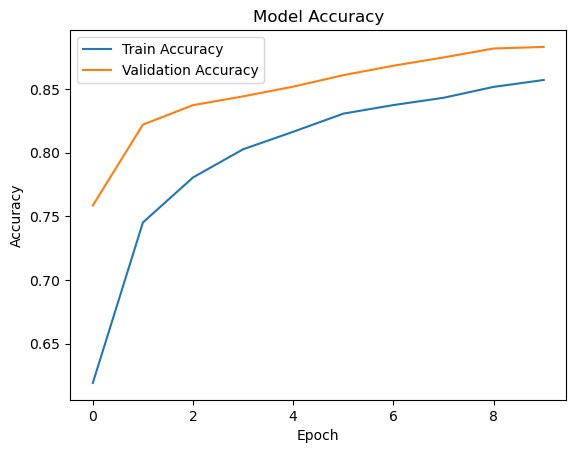

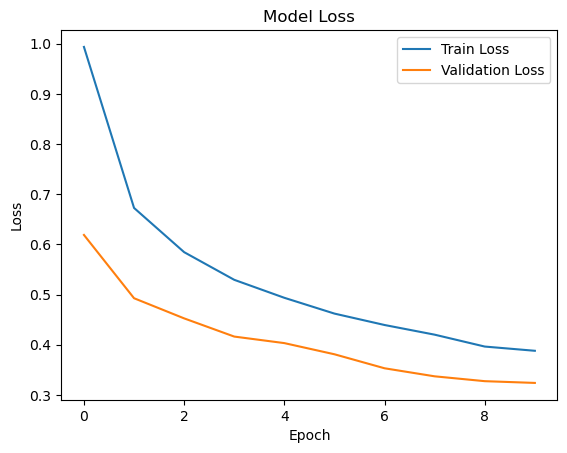

Training model 2/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: tanh, pool_type: Average, dropout_rate: 0.2, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5285 - loss: 1.2367 - val_accuracy: 0.7283 - val_loss: 0.7335
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7241 - loss: 0.7409 - val_accuracy: 0.7425 - val_loss: 0.6654
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7611 - loss: 0.6455 - val_accuracy: 0.7617 - val_loss: 0.6281
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7804 - loss: 0.5836 - val_accuracy: 0.7574 - val_loss: 0.6123
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7845 - loss: 0.5666 - val_accuracy: 0.7796 - val_loss: 0.5730
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7957 - loss: 0.5305 - val_accuracy: 0.7921 - val_loss: 0.5567
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8018 - loss: 0.5134 - val_accuracy: 0.7875 - val_loss: 0.5492
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8146 - loss: 0.48

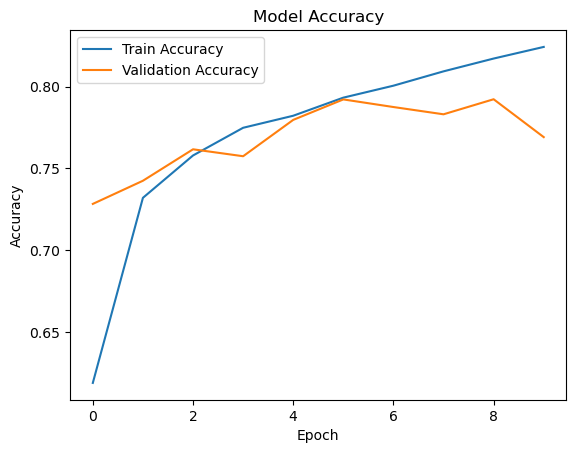

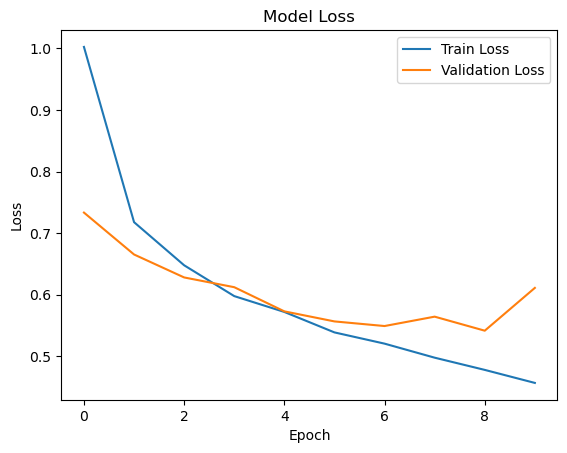

Training model 3/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5876 - loss: 1.1178 - val_accuracy: 0.7259 - val_loss: 0.7352
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7564 - loss: 0.6635 - val_accuracy: 0.7711 - val_loss: 0.6073
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7696 - loss: 0.6058 - val_accuracy: 0.7699 - val_loss: 0.6162
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7898 - loss: 0.5530 - val_accuracy: 0.7904 - val_loss: 0.5597
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.8021 - loss: 0.5272 - val_accuracy: 0.7848 - val_loss: 0.5656
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.8065 - loss: 0.5094 - val_accuracy: 0.7911 - val_loss: 0.5641
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.8182 - loss: 0.4783 - val_accuracy: 0.7937 - val_loss: 0.5510
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8204 - loss: 0.47

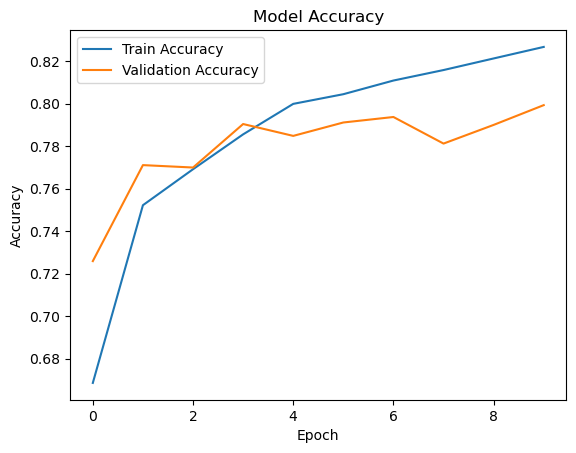

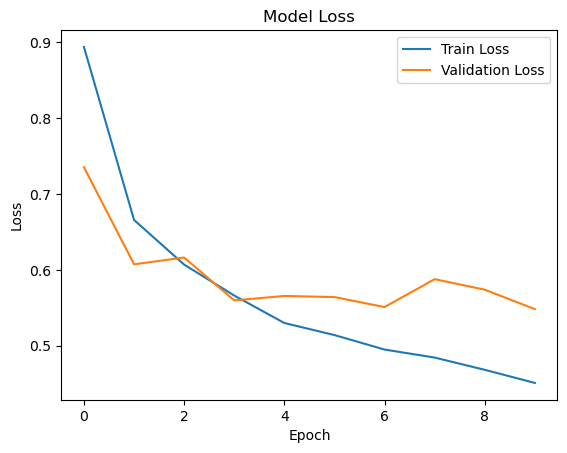

Training model 4/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: sigmoid, pool_type: Max, dropout_rate: 0.2, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.3175 - loss: 1.6896 - val_accuracy: 0.6542 - val_loss: 0.9039
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.6631 - loss: 0.8880 - val_accuracy: 0.7022 - val_loss: 0.7930
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7073 - loss: 0.7875 - val_accuracy: 0.7425 - val_loss: 0.6804
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7317 - loss: 0.7296 - val_accuracy: 0.7241 - val_loss: 0.7313
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7406 - loss: 0.6902 - val_accuracy: 0.7647 - val_loss: 0.6230
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7539 - loss: 0.6591 - val_accuracy: 0.7676 - val_loss: 0.6034
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.7590 - loss: 0.6291 - val_accuracy: 0.7662 - val_loss: 0.6297
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7647 - loss: 0.61

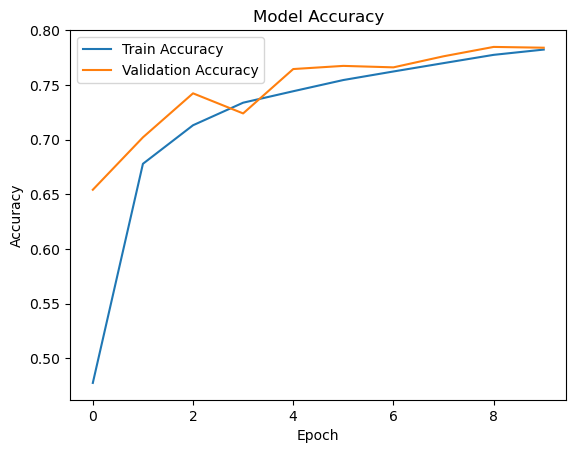

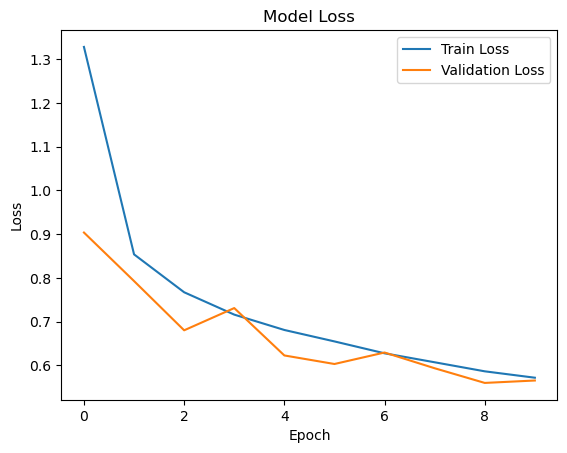

Training model 5/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.7, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.5718 - loss: 1.1462 - val_accuracy: 0.7624 - val_loss: 0.6352
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.7335 - loss: 0.7057 - val_accuracy: 0.7576 - val_loss: 0.6483
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.7543 - loss: 0.6605 - val_accuracy: 0.7660 - val_loss: 0.6249
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.7614 - loss: 0.6336 - val_accuracy: 0.7890 - val_loss: 0.5742
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.7610 - loss: 0.6266 - val_accuracy: 0.7637 - val_loss: 0.6169
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.7667 - loss: 0.6171 - val_accuracy: 0.7959 - val_loss: 0.5464
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.7701 - loss: 0.6081 - val_accuracy: 0.7969 - val_loss: 0.5346
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.7672 - loss: 0.61

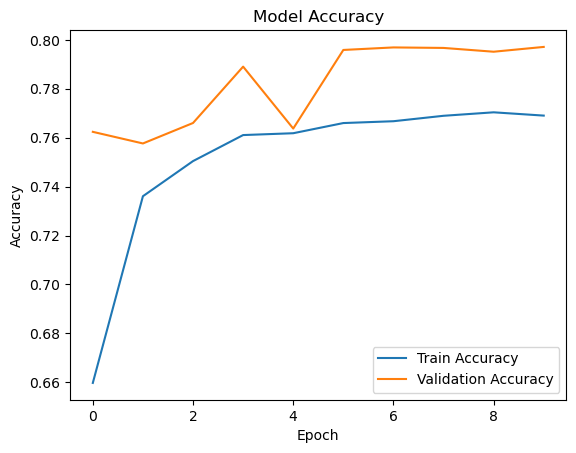

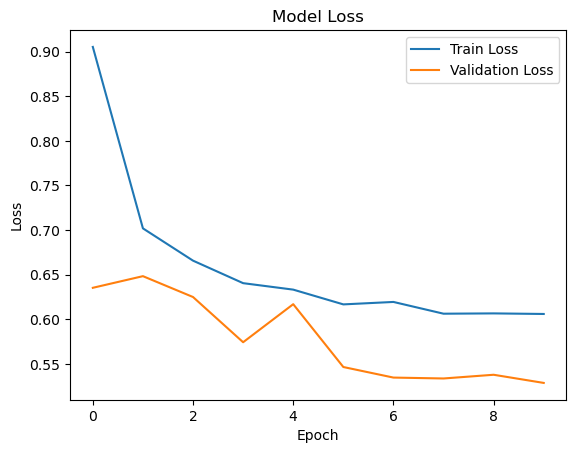

Training model 6/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.7, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4603 - loss: 1.3836 - val_accuracy: 0.7549 - val_loss: 0.6696
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7179 - loss: 0.7453 - val_accuracy: 0.7461 - val_loss: 0.6596
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7553 - loss: 0.6484 - val_accuracy: 0.8205 - val_loss: 0.4848
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7879 - loss: 0.5731 - val_accuracy: 0.8352 - val_loss: 0.4440
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8020 - loss: 0.5402 - val_accuracy: 0.8441 - val_loss: 0.4210
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8151 - loss: 0.4975 - val_accuracy: 0.8580 - val_loss: 0.3901
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8181 - loss: 0.4832 - val_accuracy: 0.8589 - val_loss: 0.3845
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8300 - loss: 0.45

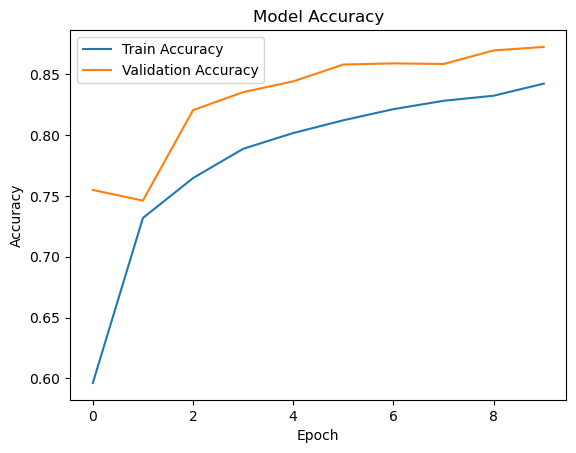

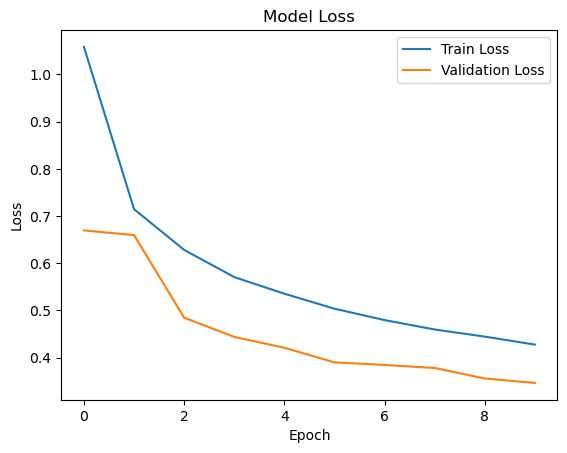

Training model 7/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5160 - loss: 1.2626 - val_accuracy: 0.7590 - val_loss: 0.6374
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7508 - loss: 0.6684 - val_accuracy: 0.7980 - val_loss: 0.5398
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7917 - loss: 0.5591 - val_accuracy: 0.8164 - val_loss: 0.4912
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8202 - loss: 0.4807 - val_accuracy: 0.8341 - val_loss: 0.4493
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8422 - loss: 0.4374 - val_accuracy: 0.8460 - val_loss: 0.4051
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8488 - loss: 0.4130 - val_accuracy: 0.8566 - val_loss: 0.3861
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8539 - loss: 0.3841 - val_accuracy: 0.8545 - val_loss: 0.3927
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8683 - loss: 0.35

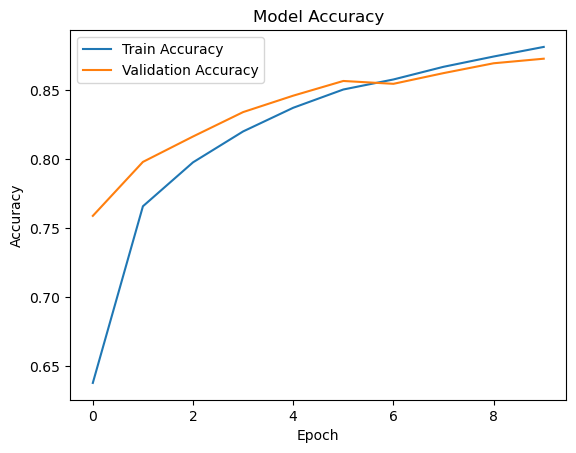

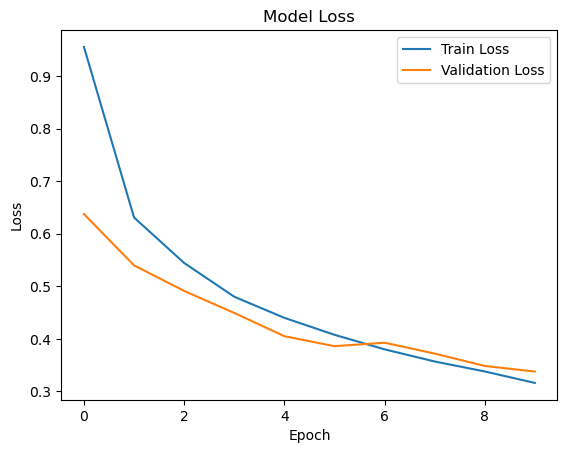

Training model 8/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: sigmoid, pool_type: Average, dropout_rate: 0.7, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2661 - loss: 1.8207 - val_accuracy: 0.4951 - val_loss: 1.2493
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5021 - loss: 1.2398 - val_accuracy: 0.5692 - val_loss: 1.1110
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5512 - loss: 1.1354 - val_accuracy: 0.6500 - val_loss: 0.9664
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6354 - loss: 0.9682 - val_accuracy: 0.6982 - val_loss: 0.8063
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6721 - loss: 0.8786 - val_accuracy: 0.7286 - val_loss: 0.7534
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6920 - loss: 0.8261 - val_accuracy: 0.7086 - val_loss: 0.7485
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6985 - loss: 0.8066 - val_accuracy: 0.7489 - val_loss: 0.6899
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7180 - loss: 0.75

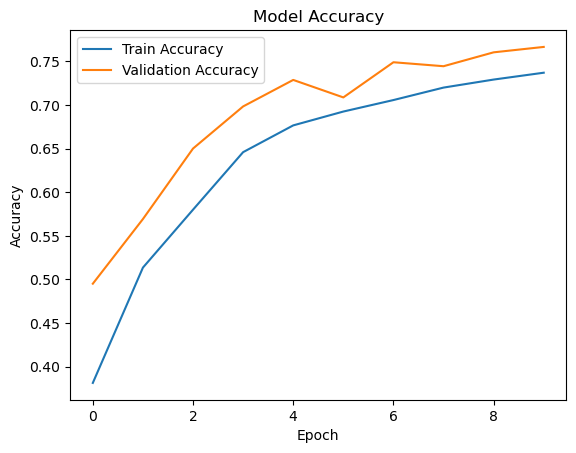

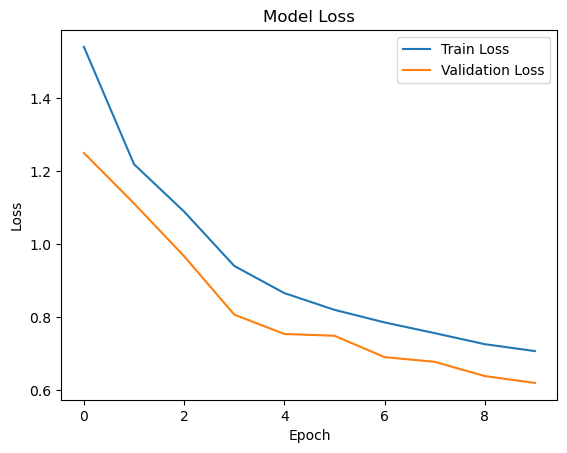

Training model 9/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5786 - loss: 1.1275 - val_accuracy: 0.7560 - val_loss: 0.6462
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.7524 - loss: 0.6592 - val_accuracy: 0.7696 - val_loss: 0.6028
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7901 - loss: 0.5563 - val_accuracy: 0.7866 - val_loss: 0.5627
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8064 - loss: 0.5039 - val_accuracy: 0.7698 - val_loss: 0.6120
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.8286 - loss: 0.4488 - val_accuracy: 0.7821 - val_loss: 0.5590
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.8429 - loss: 0.4131 - val_accuracy: 0.7853 - val_loss: 0.5614
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.8561 - loss: 0.3736 - val_accuracy: 0.7902 - val_loss: 0.5812
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8662 - loss: 0.34

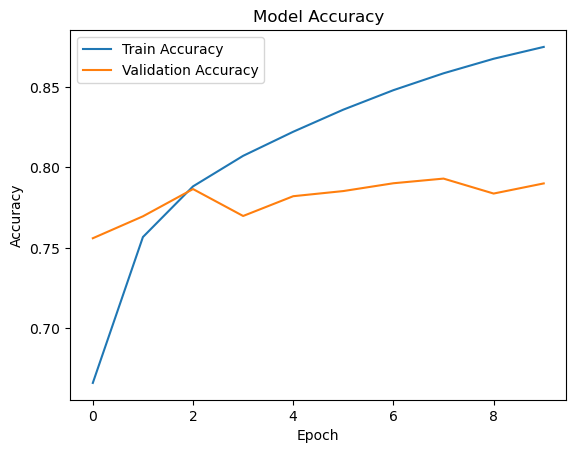

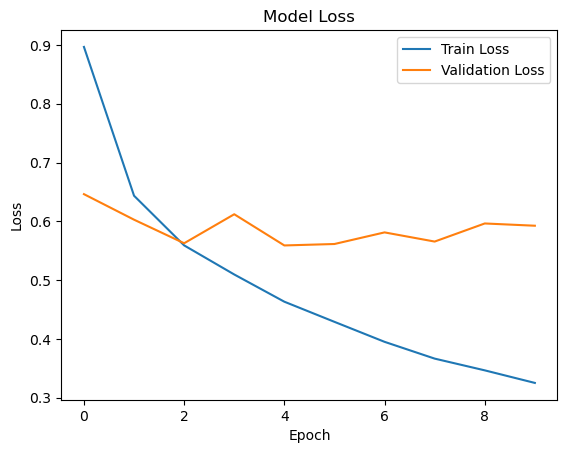

Training model 10/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4768 - loss: 1.3406 - val_accuracy: 0.7440 - val_loss: 0.6860
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7239 - loss: 0.7272 - val_accuracy: 0.8093 - val_loss: 0.5175
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7707 - loss: 0.6196 - val_accuracy: 0.8214 - val_loss: 0.4913
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7949 - loss: 0.5472 - val_accuracy: 0.8478 - val_loss: 0.4205
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8090 - loss: 0.5109 - val_accuracy: 0.8542 - val_loss: 0.4067
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8226 - loss: 0.4723 - val_accuracy: 0.8556 - val_loss: 0.3921
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8335 - loss: 0.4481 - val_accuracy: 0.8562 - val_loss: 0.3834
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8407 - loss: 0.42

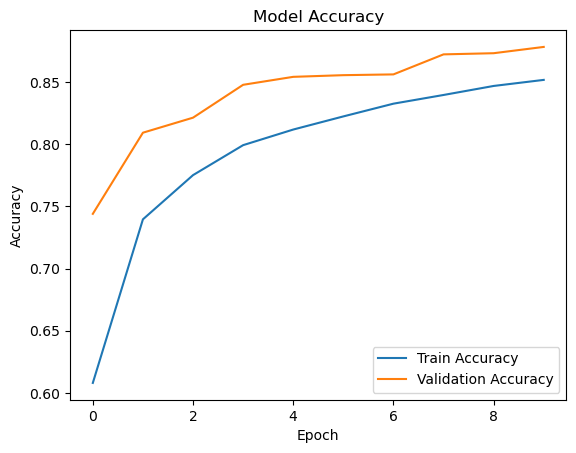

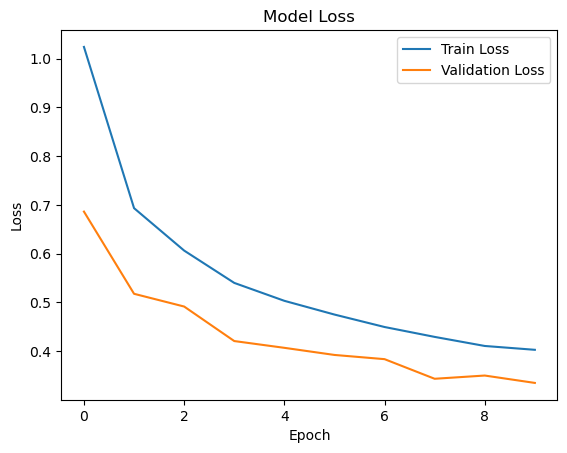

Training model 11/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Average, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.4377 - loss: 1.4894 - val_accuracy: 0.6461 - val_loss: 0.9392
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6218 - loss: 0.9982 - val_accuracy: 0.6750 - val_loss: 0.8411
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.6754 - loss: 0.8617 - val_accuracy: 0.7072 - val_loss: 0.7680
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6991 - loss: 0.7993 - val_accuracy: 0.7192 - val_loss: 0.7149
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7139 - loss: 0.7630 - val_accuracy: 0.7219 - val_loss: 0.7326
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.7158 - loss: 0.7457 - val_accuracy: 0.7262 - val_loss: 0.7111
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.7211 - loss: 0.7369 - val_accuracy: 0.7671 - val_loss: 0.6216
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7236 - loss: 0.71

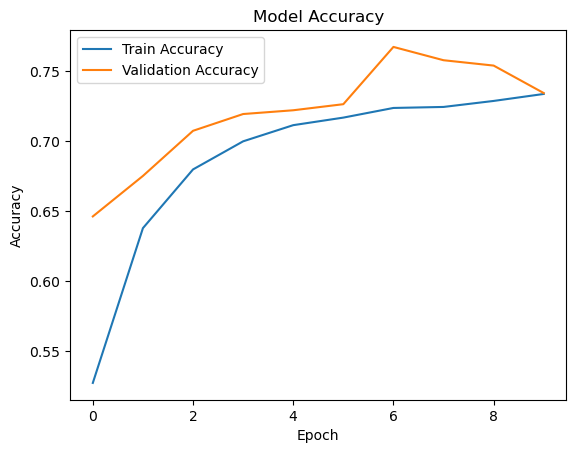

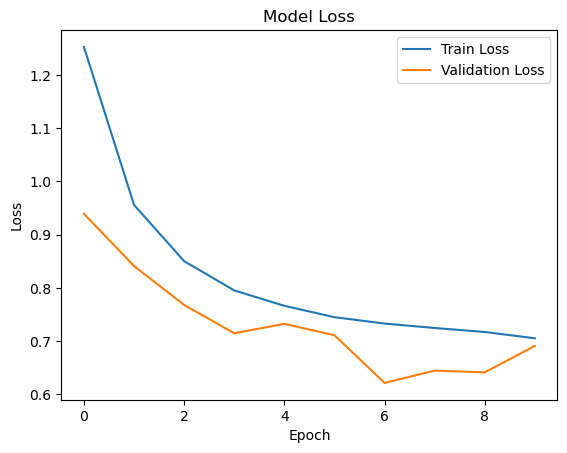

Training model 12/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: sigmoid, pool_type: Average, dropout_rate: 0.5, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.3362 - loss: 1.6531 - val_accuracy: 0.5187 - val_loss: 1.1975
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.5503 - loss: 1.1645 - val_accuracy: 0.6313 - val_loss: 0.9553
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6139 - loss: 1.0138 - val_accuracy: 0.6559 - val_loss: 0.9000
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6577 - loss: 0.9119 - val_accuracy: 0.7066 - val_loss: 0.7802
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6904 - loss: 0.8251 - val_accuracy: 0.7174 - val_loss: 0.7401
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.7078 - loss: 0.7817 - val_accuracy: 0.7248 - val_loss: 0.7212
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7249 - loss: 0.7389 - val_accuracy: 0.7509 - val_loss: 0.6588
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7364 - loss: 0.70

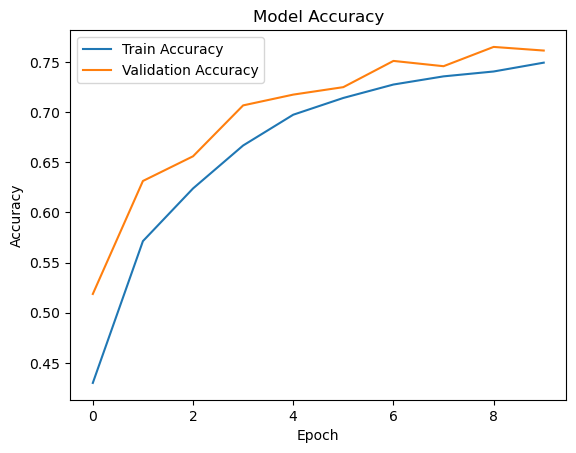

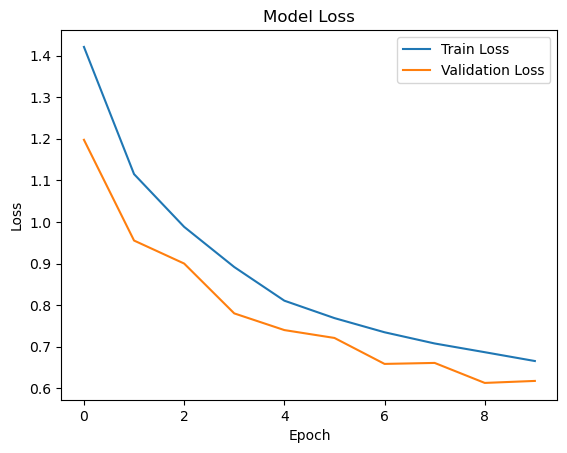

Training model 13/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: sigmoid, pool_type: Average, dropout_rate: 0.5, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3078 - loss: 1.7313 - val_accuracy: 0.5987 - val_loss: 1.0663
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6016 - loss: 1.0611 - val_accuracy: 0.6763 - val_loss: 0.9268
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6630 - loss: 0.8991 - val_accuracy: 0.6990 - val_loss: 0.7818
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.6959 - loss: 0.8147 - val_accuracy: 0.7356 - val_loss: 0.7072
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7136 - loss: 0.7688 - val_accuracy: 0.7466 - val_loss: 0.6647
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7309 - loss: 0.7318 - val_accuracy: 0.7600 - val_loss: 0.6504
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7351 - loss: 0.7042 - val_accuracy: 0.7626 - val_loss: 0.6203
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7431 - loss: 0.68

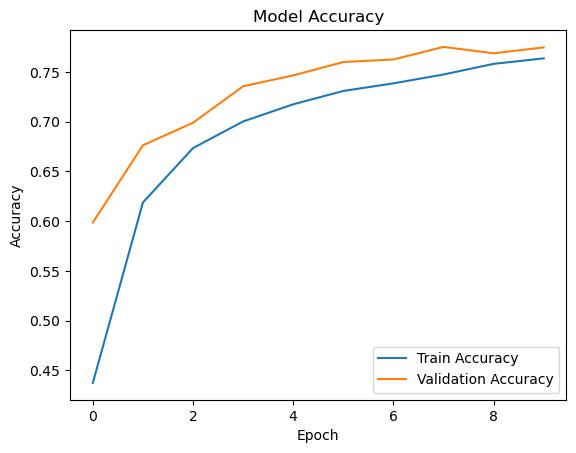

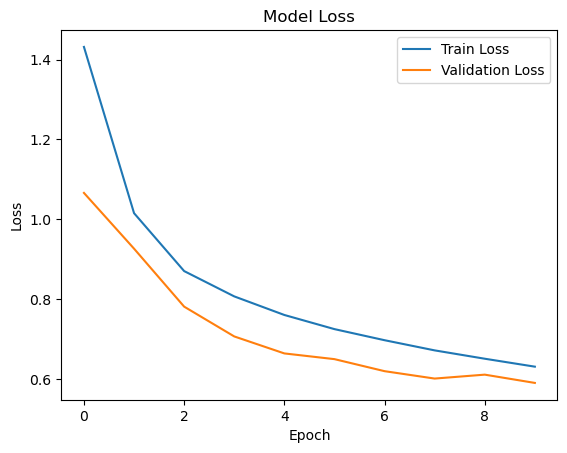

Training model 14/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: sigmoid, pool_type: Max, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.3482 - loss: 1.6327 - val_accuracy: 0.5880 - val_loss: 1.1014
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.5930 - loss: 1.0738 - val_accuracy: 0.6726 - val_loss: 0.8522
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6836 - loss: 0.8482 - val_accuracy: 0.7147 - val_loss: 0.7512
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7179 - loss: 0.7647 - val_accuracy: 0.7263 - val_loss: 0.7194
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7329 - loss: 0.7222 - val_accuracy: 0.7593 - val_loss: 0.6489
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.7452 - loss: 0.6879 - val_accuracy: 0.7541 - val_loss: 0.6519
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7510 - loss: 0.6669 - val_accuracy: 0.7685 - val_loss: 0.6209
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7547 - loss: 0.65

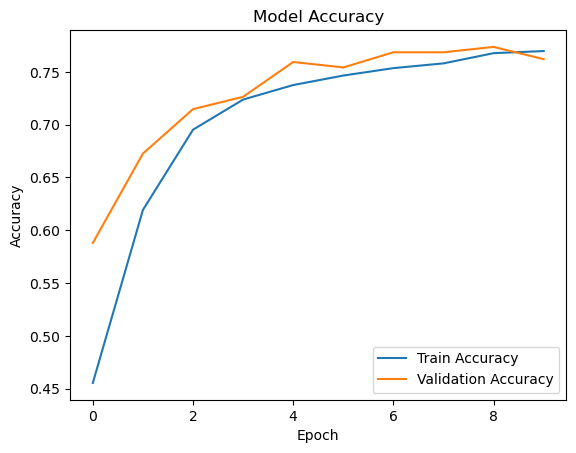

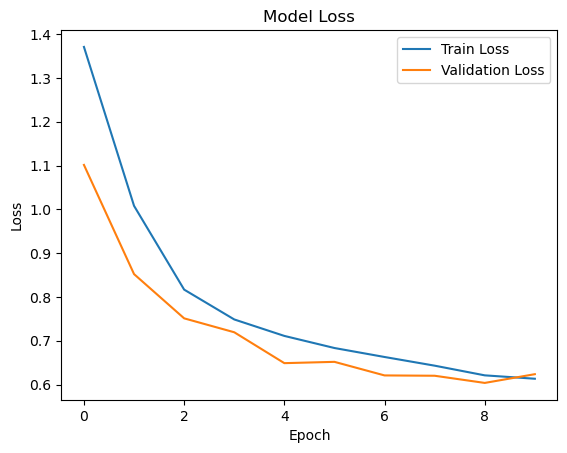

Training model 15/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.5, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5447 - loss: 1.2213 - val_accuracy: 0.7240 - val_loss: 0.7244
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7153 - loss: 0.7644 - val_accuracy: 0.7378 - val_loss: 0.7002
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7411 - loss: 0.6865 - val_accuracy: 0.7888 - val_loss: 0.5667
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7563 - loss: 0.6448 - val_accuracy: 0.7819 - val_loss: 0.5750
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7777 - loss: 0.5935 - val_accuracy: 0.7898 - val_loss: 0.5479
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7768 - loss: 0.5911 - val_accuracy: 0.7916 - val_loss: 0.5484
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7890 - loss: 0.5489 - val_accuracy: 0.7913 - val_loss: 0.5398
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7832 - loss: 0.55

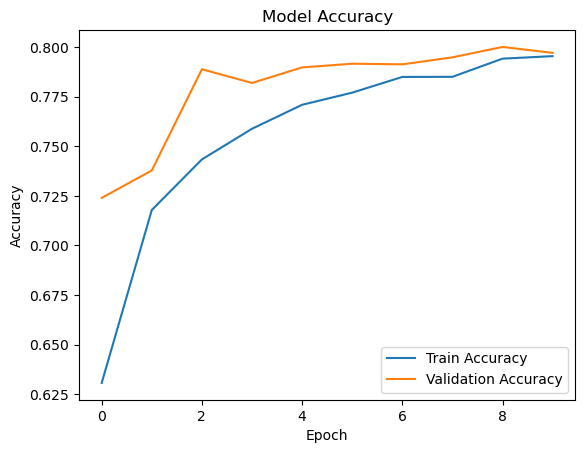

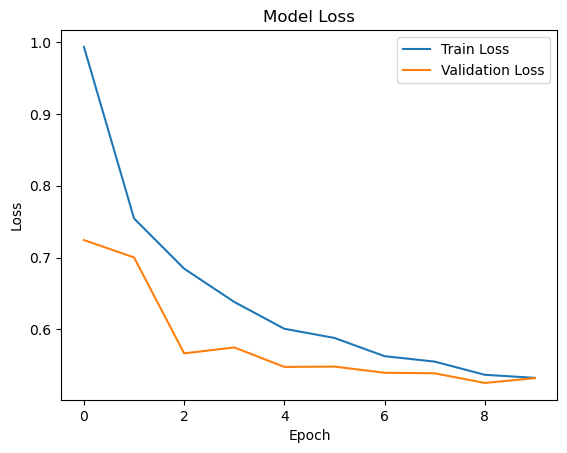

Training model 16/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Average, dropout_rate: 0.7, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.4631 - loss: 1.4156 - val_accuracy: 0.6694 - val_loss: 0.8577
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.6424 - loss: 0.9482 - val_accuracy: 0.6362 - val_loss: 0.9463
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.6733 - loss: 0.8733 - val_accuracy: 0.7175 - val_loss: 0.7264
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.6927 - loss: 0.8184 - val_accuracy: 0.7362 - val_loss: 0.6925
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.7013 - loss: 0.7884 - val_accuracy: 0.7286 - val_loss: 0.7057
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7073 - loss: 0.7793 - val_accuracy: 0.7421 - val_loss: 0.6673
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.7125 - loss: 0.7650 - val_accuracy: 0.7401 - val_loss: 0.6814
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.7180 - loss: 0.74

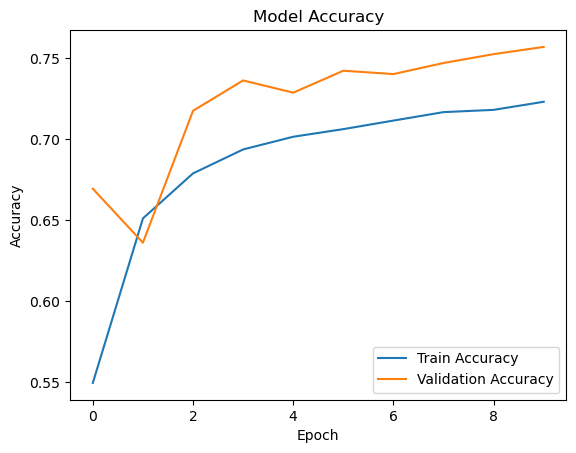

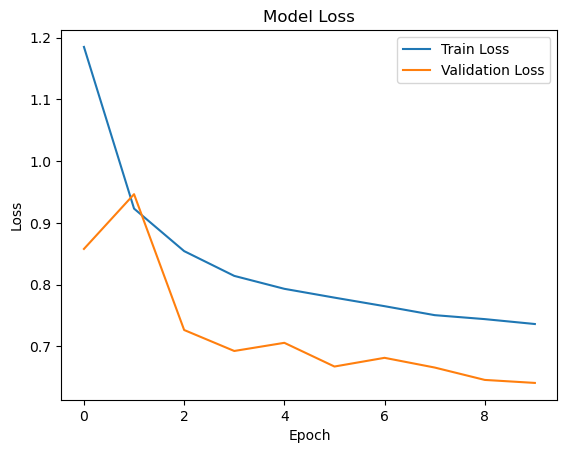

Training model 17/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.5817 - loss: 1.1283 - val_accuracy: 0.7340 - val_loss: 0.6978
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.7573 - loss: 0.6491 - val_accuracy: 0.7569 - val_loss: 0.6265
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7816 - loss: 0.5756 - val_accuracy: 0.7789 - val_loss: 0.5819
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7997 - loss: 0.5289 - val_accuracy: 0.7601 - val_loss: 0.6142
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8117 - loss: 0.4948 - val_accuracy: 0.7934 - val_loss: 0.5523
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8299 - loss: 0.4515 - val_accuracy: 0.7838 - val_loss: 0.5825
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8309 - loss: 0.4345 - val_accuracy: 0.7946 - val_loss: 0.5537
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8391 - loss: 0.42

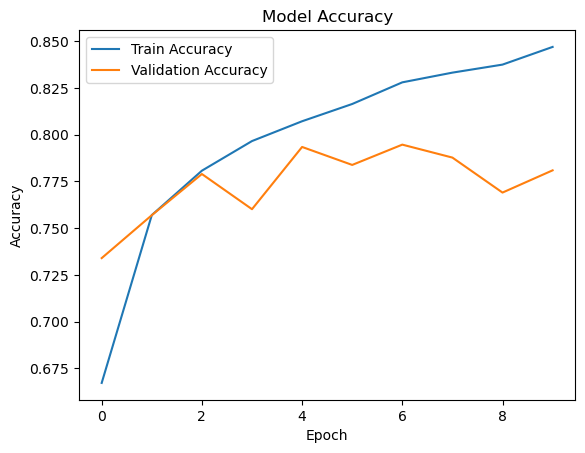

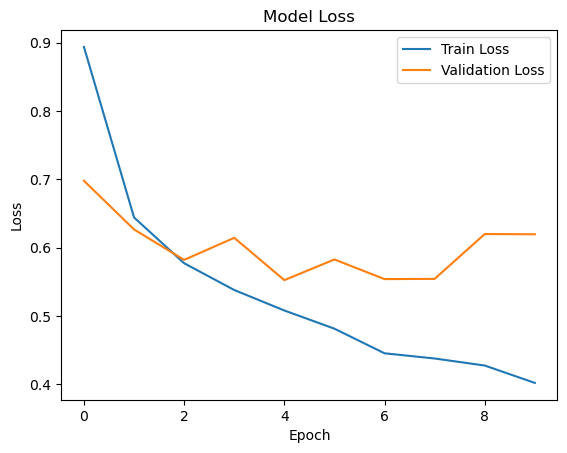

Training model 18/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: sigmoid, pool_type: Average, dropout_rate: 0.5, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.1576 - loss: 2.0614 - val_accuracy: 0.5134 - val_loss: 1.2415
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5288 - loss: 1.2056 - val_accuracy: 0.6169 - val_loss: 0.9930
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6352 - loss: 0.9594 - val_accuracy: 0.6844 - val_loss: 0.8359
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6737 - loss: 0.8669 - val_accuracy: 0.7054 - val_loss: 0.7797
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6988 - loss: 0.8027 - val_accuracy: 0.7319 - val_loss: 0.6879
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7184 - loss: 0.7502 - val_accuracy: 0.7602 - val_loss: 0.6410
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7364 - loss: 0.7058 - val_accuracy: 0.7718 - val_loss: 0.6105
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7457 - loss: 0.67

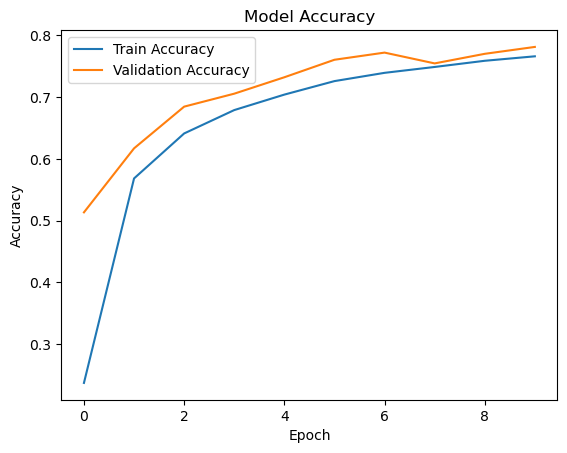

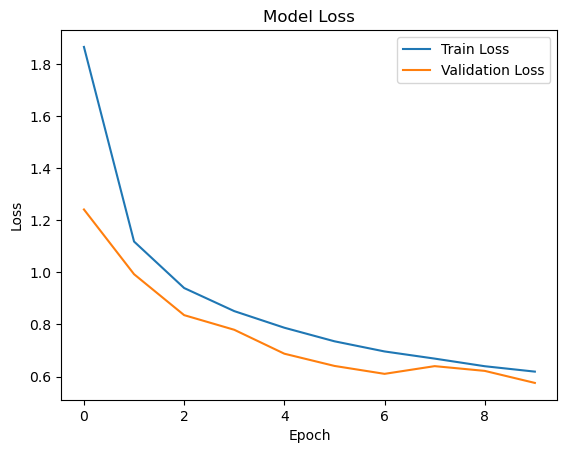

Training model 19/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: sigmoid, pool_type: Max, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.2899 - loss: 1.7510 - val_accuracy: 0.5173 - val_loss: 1.2516
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5099 - loss: 1.2558 - val_accuracy: 0.5926 - val_loss: 1.0658
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5712 - loss: 1.1267 - val_accuracy: 0.6229 - val_loss: 0.9942
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6006 - loss: 1.0544 - val_accuracy: 0.6261 - val_loss: 0.9463
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6244 - loss: 0.9870 - val_accuracy: 0.6593 - val_loss: 0.8643
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6558 - loss: 0.9050 - val_accuracy: 0.6939 - val_loss: 0.7822
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6785 - loss: 0.8597 - val_accuracy: 0.7173 - val_loss: 0.7452
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6899 - loss: 0.82

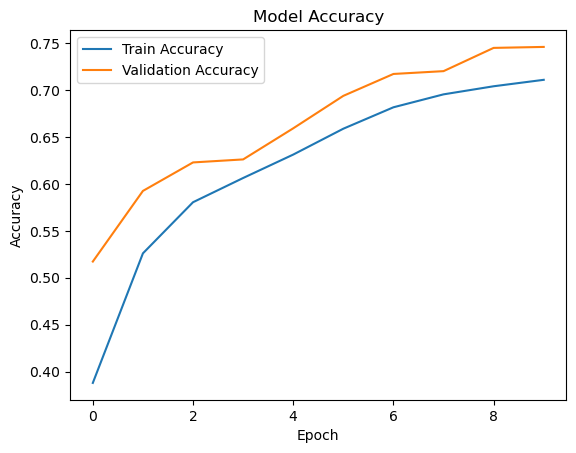

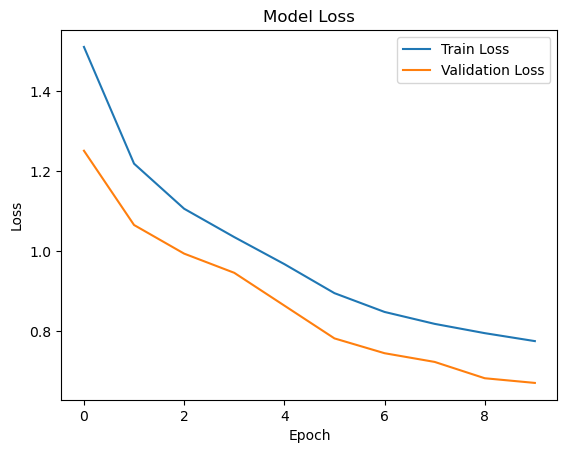

Training model 20/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.7, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4407 - loss: 1.4513 - val_accuracy: 0.7187 - val_loss: 0.7369
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.6855 - loss: 0.8388 - val_accuracy: 0.7216 - val_loss: 0.7591
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7354 - loss: 0.7156 - val_accuracy: 0.7780 - val_loss: 0.5960
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7561 - loss: 0.6619 - val_accuracy: 0.7579 - val_loss: 0.6606
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7720 - loss: 0.6124 - val_accuracy: 0.8086 - val_loss: 0.5178
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7822 - loss: 0.5841 - val_accuracy: 0.8043 - val_loss: 0.5190
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7899 - loss: 0.5630 - val_accuracy: 0.7980 - val_loss: 0.5428
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7976 - loss: 0.53

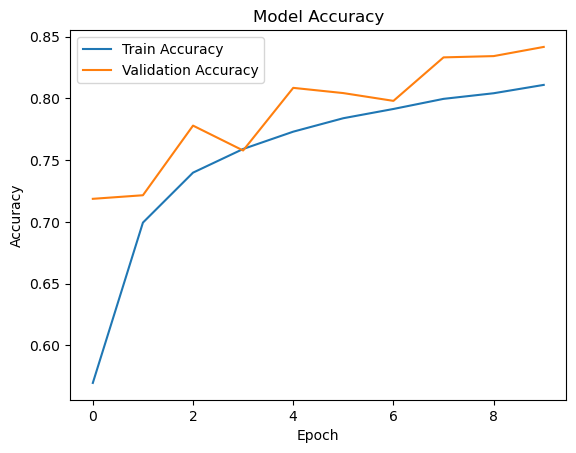

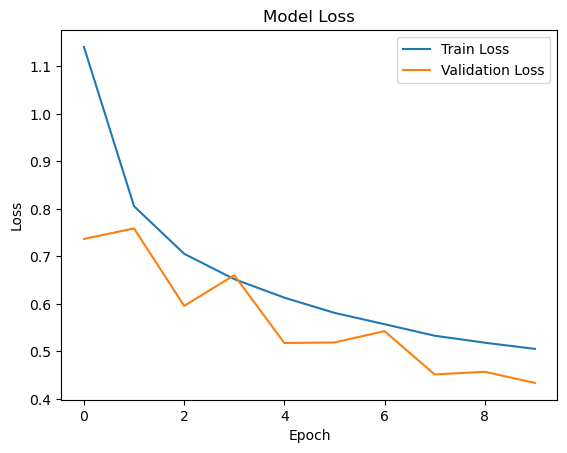

Training model 21/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.5775 - loss: 1.1341 - val_accuracy: 0.7397 - val_loss: 0.7060
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7484 - loss: 0.6759 - val_accuracy: 0.7246 - val_loss: 0.7341
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.7693 - loss: 0.6148 - val_accuracy: 0.7621 - val_loss: 0.6255
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7879 - loss: 0.5622 - val_accuracy: 0.7750 - val_loss: 0.5868
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8050 - loss: 0.5174 - val_accuracy: 0.7817 - val_loss: 0.5716
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8033 - loss: 0.5103 - val_accuracy: 0.7785 - val_loss: 0.5828
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.8133 - loss: 0.4965 - val_accuracy: 0.7854 - val_loss: 0.5720
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8152 - loss: 0.48

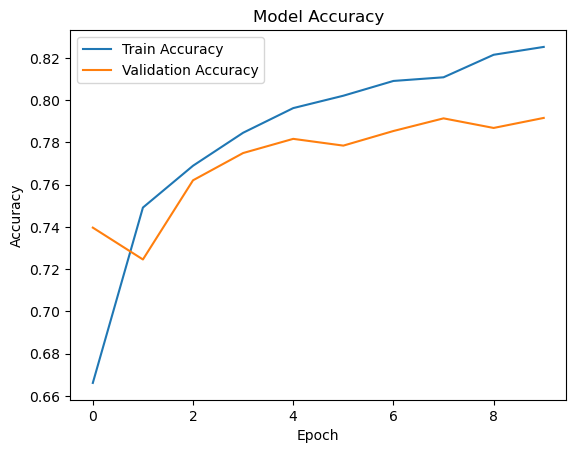

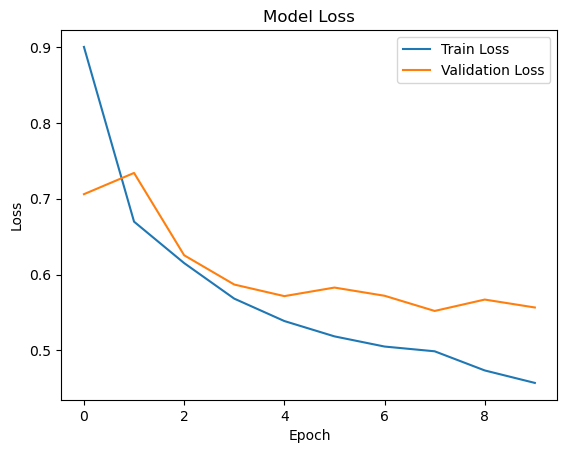

Training model 22/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5714 - loss: 1.1452 - val_accuracy: 0.7538 - val_loss: 0.6564
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7406 - loss: 0.6987 - val_accuracy: 0.7684 - val_loss: 0.6110
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7735 - loss: 0.5993 - val_accuracy: 0.7731 - val_loss: 0.6136
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7864 - loss: 0.5596 - val_accuracy: 0.7728 - val_loss: 0.5986
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8005 - loss: 0.5304 - val_accuracy: 0.7884 - val_loss: 0.5552
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8107 - loss: 0.4978 - val_accuracy: 0.7881 - val_loss: 0.5522
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8241 - loss: 0.4677 - val_accuracy: 0.7937 - val_loss: 0.5439
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8261 - loss: 0.45

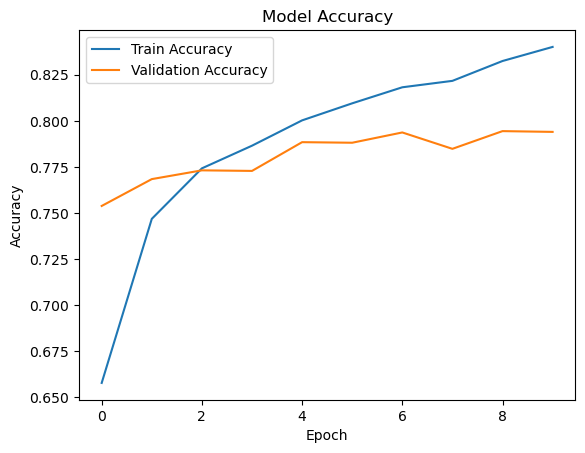

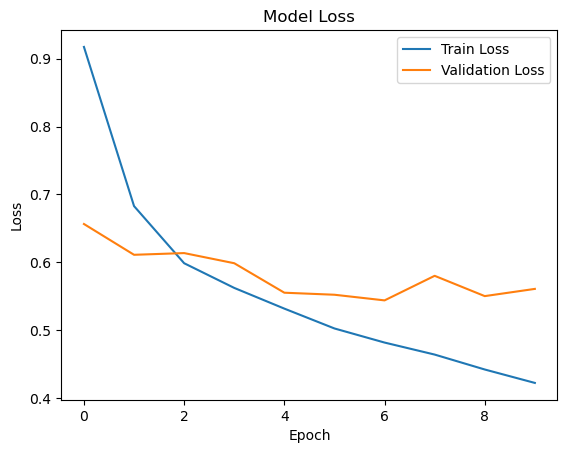

Training model 23/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4420 - loss: 1.4367 - val_accuracy: 0.6862 - val_loss: 0.8157
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6748 - loss: 0.8758 - val_accuracy: 0.7425 - val_loss: 0.6887
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7123 - loss: 0.7798 - val_accuracy: 0.7826 - val_loss: 0.5846
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7374 - loss: 0.7073 - val_accuracy: 0.7889 - val_loss: 0.5644
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7539 - loss: 0.6573 - val_accuracy: 0.7918 - val_loss: 0.5545
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7657 - loss: 0.6297 - val_accuracy: 0.7767 - val_loss: 0.5987
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7711 - loss: 0.6150 - val_accuracy: 0.8082 - val_loss: 0.5173
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7879 - loss: 0.57

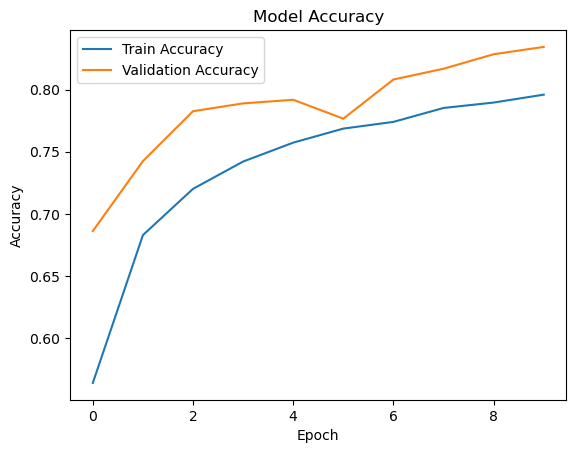

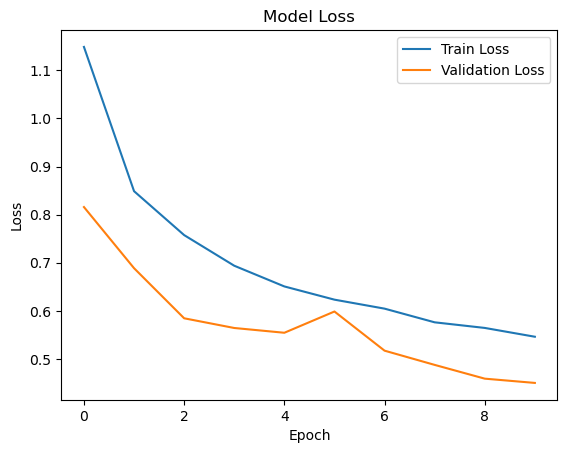

Training model 24/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Max, dropout_rate: 0.2, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5914 - loss: 1.0660 - val_accuracy: 0.8066 - val_loss: 0.5219
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8111 - loss: 0.5048 - val_accuracy: 0.8495 - val_loss: 0.4031
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8549 - loss: 0.3930 - val_accuracy: 0.8617 - val_loss: 0.3853
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.8764 - loss: 0.3311 - val_accuracy: 0.8666 - val_loss: 0.3594
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.8943 - loss: 0.2811 - val_accuracy: 0.8725 - val_loss: 0.3513
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9118 - loss: 0.2384 - val_accuracy: 0.8756 - val_loss: 0.3411
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9254 - loss: 0.2028 - val_accuracy: 0.8813 - val_loss: 0.3433
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9402 - loss: 0.16

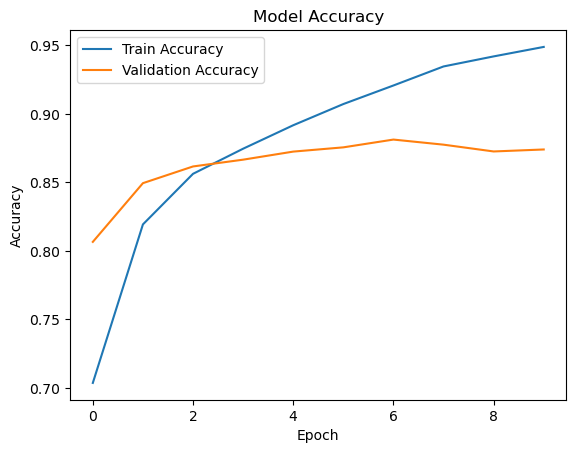

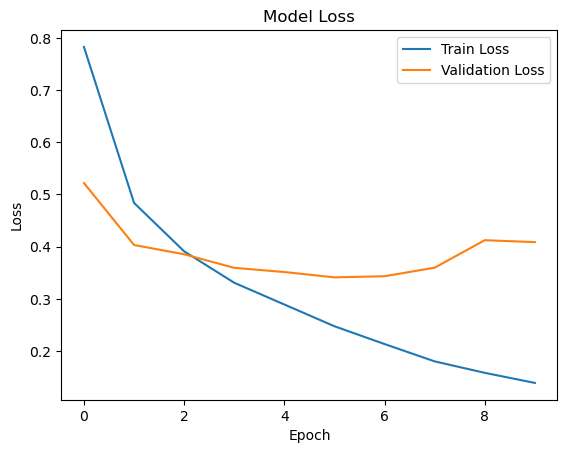

Training model 25/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: tanh, pool_type: Max, dropout_rate: 0.2, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.5842 - loss: 1.1146 - val_accuracy: 0.7521 - val_loss: 0.6555
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7546 - loss: 0.6508 - val_accuracy: 0.7683 - val_loss: 0.6043
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7919 - loss: 0.5521 - val_accuracy: 0.7910 - val_loss: 0.5464
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8145 - loss: 0.4899 - val_accuracy: 0.7804 - val_loss: 0.5641
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8299 - loss: 0.4426 - val_accuracy: 0.7871 - val_loss: 0.5631
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8394 - loss: 0.4211 - val_accuracy: 0.7881 - val_loss: 0.5832
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8538 - loss: 0.3763 - val_accuracy: 0.8010 - val_loss: 0.5445
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8644 - loss: 0.35

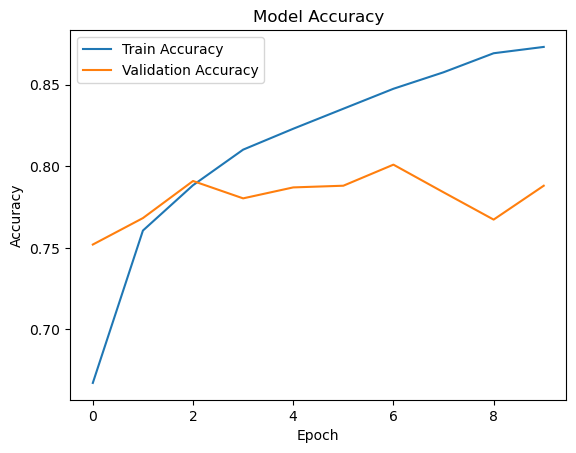

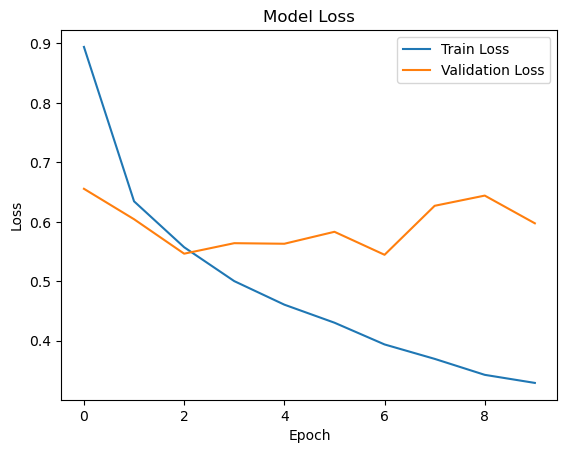

Training model 26/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: sigmoid, pool_type: Average, dropout_rate: 0.2, dense_units: 128


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.2557 - loss: 1.8468 - val_accuracy: 0.6698 - val_loss: 0.9149
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6758 - loss: 0.8688 - val_accuracy: 0.7281 - val_loss: 0.7242
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7269 - loss: 0.7265 - val_accuracy: 0.7648 - val_loss: 0.6376
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7549 - loss: 0.6571 - val_accuracy: 0.7670 - val_loss: 0.5943
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7734 - loss: 0.6036 - val_accuracy: 0.7737 - val_loss: 0.5772
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7813 - loss: 0.5751 - val_accuracy: 0.7861 - val_loss: 0.5643
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7927 - loss: 0.5513 - val_accuracy: 0.7932 - val_loss: 0.5435
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7978 - loss: 0.53

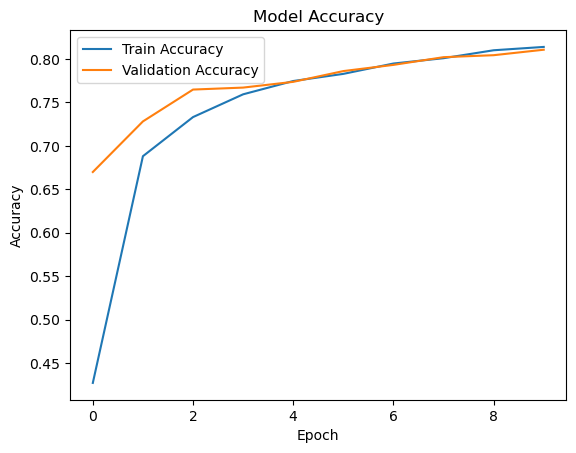

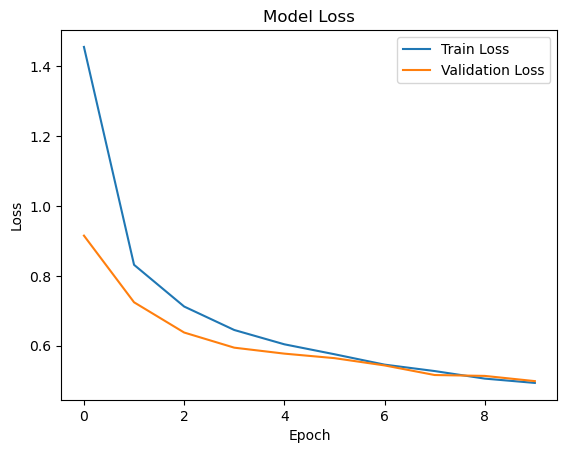

Training model 27/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.5, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4587 - loss: 1.4024 - val_accuracy: 0.7086 - val_loss: 0.7402
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6936 - loss: 0.8208 - val_accuracy: 0.7542 - val_loss: 0.6534
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7274 - loss: 0.7235 - val_accuracy: 0.7810 - val_loss: 0.5874
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7584 - loss: 0.6525 - val_accuracy: 0.7932 - val_loss: 0.5706
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7677 - loss: 0.6170 - val_accuracy: 0.8051 - val_loss: 0.5190
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7820 - loss: 0.5727 - val_accuracy: 0.8164 - val_loss: 0.4792
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7879 - loss: 0.5609 - val_accuracy: 0.8192 - val_loss: 0.4907
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7998 - loss: 0.5375 -

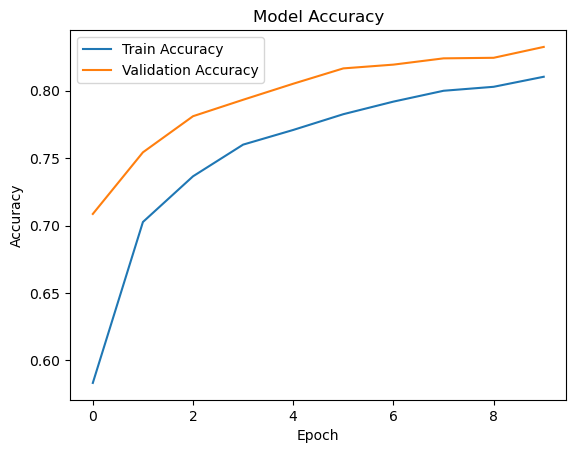

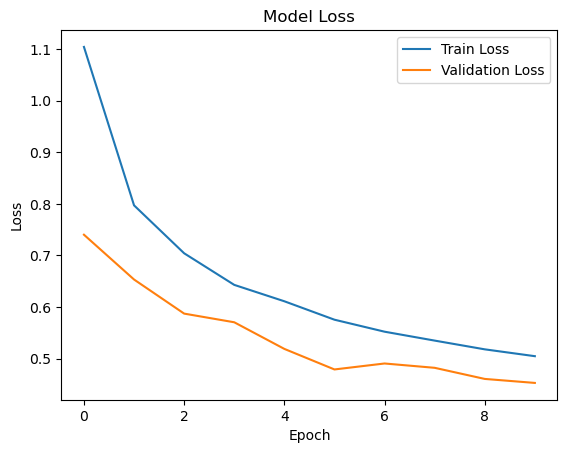

Training model 28/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Average, dropout_rate: 0.2, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5508 - loss: 1.1594 - val_accuracy: 0.7794 - val_loss: 0.5904
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7908 - loss: 0.5600 - val_accuracy: 0.8377 - val_loss: 0.4355
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8335 - loss: 0.4456 - val_accuracy: 0.8405 - val_loss: 0.4141
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8566 - loss: 0.3811 - val_accuracy: 0.8653 - val_loss: 0.3674
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8768 - loss: 0.3303 - val_accuracy: 0.8717 - val_loss: 0.3336
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8858 - loss: 0.2996 - val_accuracy: 0.8730 - val_loss: 0.3405
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8987 - loss: 0.2746 - val_accuracy: 0.8824 - val_loss: 0.3163
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9091 - loss: 0.24

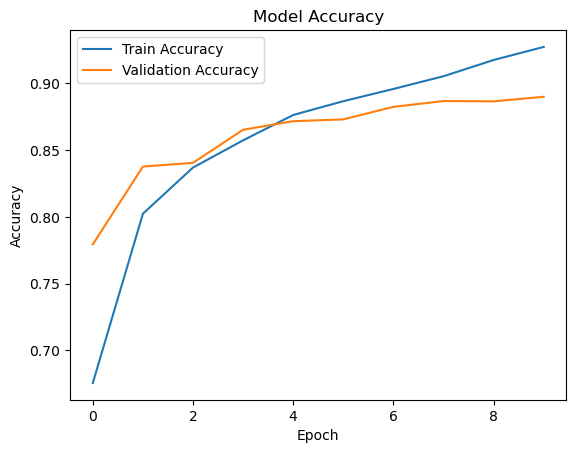

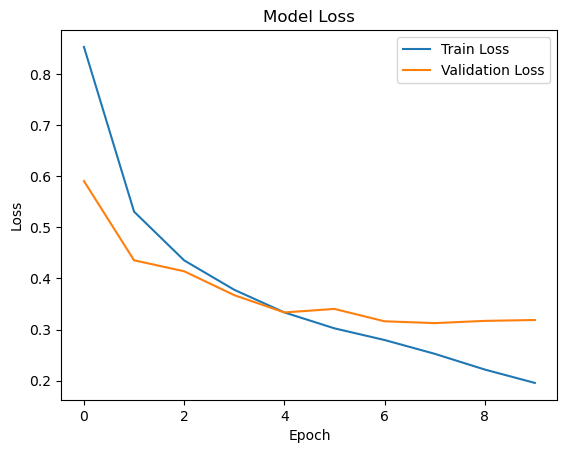

Training model 29/30 with parameters:
filter_sizes: (64, 128, 256), kernel_sizes: ((5, 5), (3, 3), (3, 3)), activation: relu, pool_type: Max, dropout_rate: 0.2, dense_units: 64


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5315 - loss: 1.2364 - val_accuracy: 0.7244 - val_loss: 0.7335
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7599 - loss: 0.6445 - val_accuracy: 0.7944 - val_loss: 0.5530
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8004 - loss: 0.5386 - val_accuracy: 0.8131 - val_loss: 0.4941
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8182 - loss: 0.4845 - val_accuracy: 0.8142 - val_loss: 0.4969
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8331 - loss: 0.4386 - val_accuracy: 0.8310 - val_loss: 0.4645
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8423 - loss: 0.4131 - val_accuracy: 0.8243 - val_loss: 0.4721
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8525 - loss: 0.3840 - val_accuracy: 0.8293 - val_loss: 0.4622
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8708 - loss: 0.33

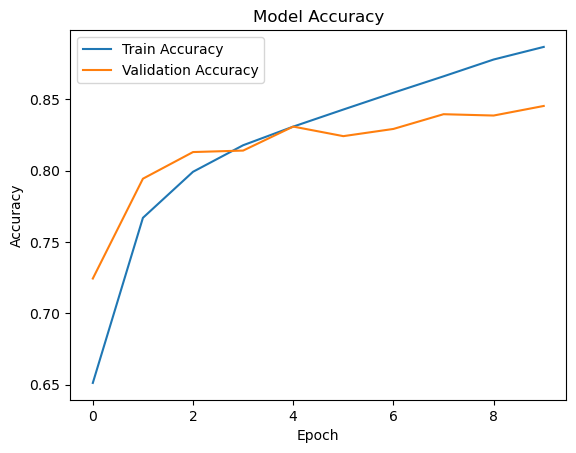

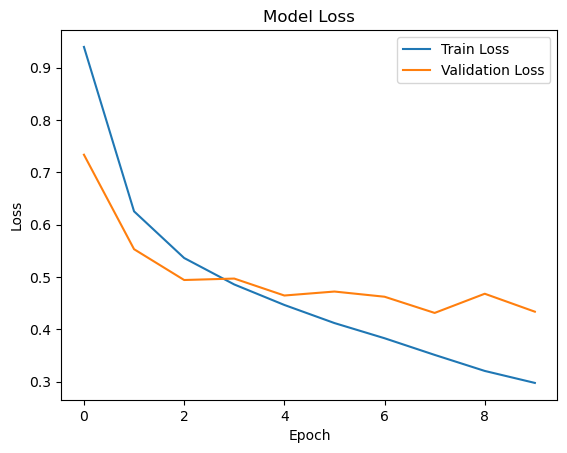

Training model 30/30 with parameters:
filter_sizes: (32, 64, 128), kernel_sizes: ((3, 3), (3, 3), (3, 3)), activation: relu, pool_type: Max, dropout_rate: 0.7, dense_units: 256


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Users/haleystafford/miniforge3/envs/matsci166/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1210/1210 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5258 - loss: 1.2418 - val_accuracy: 0.7747 - val_loss: 0.6033
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7494 - loss: 0.6735 - val_accuracy: 0.8159 - val_loss: 0.5016
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7856 - loss: 0.5768 - val_accuracy: 0.8385 - val_loss: 0.4341
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8106 - loss: 0.5124 - val_accuracy: 0.8572 - val_loss: 0.3872
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8255 - loss: 0.4674 - val_accuracy: 0.8545 - val_loss: 0.3890
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8346 - loss: 0.4429 - val_accuracy: 0.8740 - val_loss: 0.3539
Epoch 7/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8454 - loss: 0.4193 - val_accuracy: 0.8765 - val_loss: 0.3417
Epoch 8/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8508 - loss: 0.40

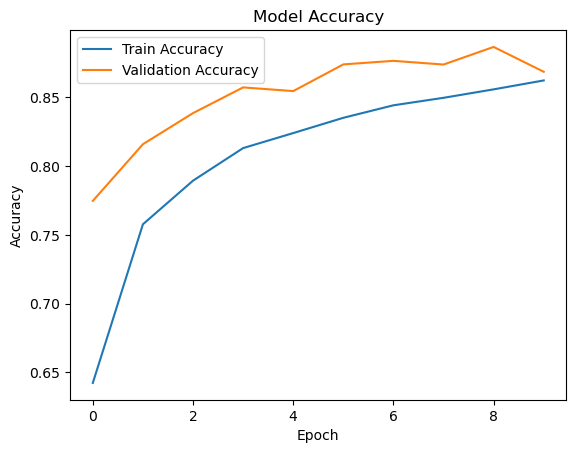

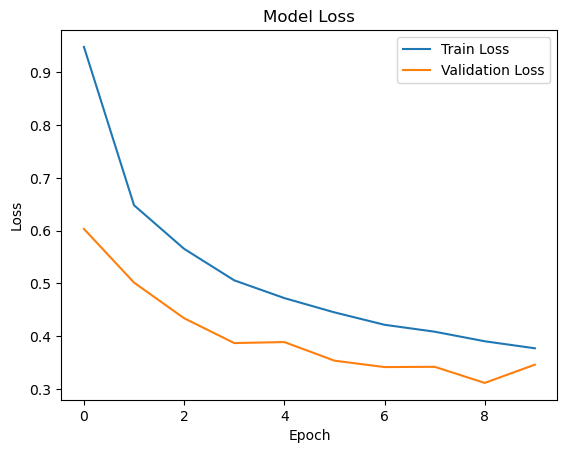


Random hyperparameter search results have been saved to 'hyperparameter_search_results.csv'.


,filter_sizes,kernel_sizes,activation,pool_type,dropout_rate,dense_units,test_accuracy,train_accuracy,val_accuracy,train_loss,val_loss,accuracy_variance,run_time
0,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",relu,Average,0.7,256,0.884628,0.857180,0.883161,0.387986,0.323933,0.025981,229.001171
1,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",tanh,Average,0.2,128,0.768843,0.824225,0.769112,0.456849,0.611179,-0.055114,229.086217
2,"(64, 128, 256)","((5, 5), (3, 3), (3, 3))",tanh,Max,0.2,64,0.790413,0.826653,0.799277,0.451039,0.548262,-0.027376,362.889386
3,"(64, 128, 256)","((5, 5), (3, 3), (3, 3))",sigmoid,Max,0.2,256,0.784793,0.782490,0.784194,0.572060,0.565667,0.001705,365.436582
4,"(64, 128, 256)","((3, 3), (3, 3), (3, 3))",tanh,Max,0.7,64,0.790000,0.769034,0.797107,0.605887,0.528593,0.028073,385.116571
5,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",relu,Average,0.7,64,0.867603,0.842226,0.872417,0.427624,0.346476,0.030191,190.075874
6,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",relu,Average,0.2,64,0.873141,0.881250,0.872727,0.316239,0.337821,-0.008523,178.493460
7,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",sigmoid,Average,0.7,64,0.764298,0.736880,0.766426,0.706500,0.619214,0.029545,180.135763
8,"(64, 128, 256)","((5, 5), (3, 3), (3, 3))",tanh,Max,0.2,256,0.786033,0.874948,0.790083,0.325159,0.592496,-0.084866,324.725891
9,"(32, 64, 128)","((3, 3), (3, 3), (3, 3))",relu,Average,0.7,256,0.872645,0.851782,0.878306,0.402583,0.334666,0.026524,185.485005


In [20]:
# Run random search to find the best hyperparameters (e.g., try 30 random combinations)
random_hyperparameter_search(defective_wafers, target_size, n_iter=30)